#### OPENCLASSROOMS - Parcours Data Scientist  
## Projet 7: Implémentez un modèle de scoring  
Etudiant: Eric Wendling  
Mentor: Julien Heiduk  
Date: 20/10/2020

**TABLE DES MATIERES**

#### [Introduction](#int)

#### [Partie 1 - Analyse et traitement des données](#ana_tra_don)

#### [Initialisation](#ini)
 
* [Import des modules Python](#imp_mod_pyt)
* [Fonctions](#fon)
* [Récupération des données](#rec_don)

#### [Analyse exploratoire des données](#ana_exp_don)

* [Description des tables](#des_tab)
* [Description des variables](#des_var)

#### [Traitement préliminaire](#tra_pre)

* [Fonctions](#fon_2)
* [Validation des fonctions](#val_fon)

#### [Traitement complet](#tra_com)

* [Corrélations](#cor)
* [Valeurs manquantes](#val_man)
* [Export des données](#exp_don)

## Introduction <a class="anchor" id="int"></a>

L'objectif du projet est la réalisation d'une application de **Crédit Scoring** dont le modèle de prédiction repose sur des technologies de Machine Learning.

Le projet est découpé en trois parties.

**Partie 1: Analyse et traitement des données**

L'analyse exploratoire des données est réalisée dans le présent notebook. Les données sources sont contenues dans des fichiers csv. Plusieurs dataframes sont produits à l'issue de cette étape.

Modèle de données: https://github.com/leerik/OC_DS_P7/blob/master/modele_donnees.pdf

**Partie 2: Modélisation d'un système d'apprentissage supervisé**

Les dataframes produits à l'étape d'analyse sont utilisés pour construire un modèle de classification.

Notebook: https://github.com/leerik/OC_DS_P7/blob/master/P7_02_scoring.ipynb

**Partie 3: Déploiement du modèle via le web**

Les résultats obtenus à l'étape de modélisation sont présentés dans une application web développée avec Dash.

Notebook: https://github.com/leerik/OC_DS_P7/blob/master/P7_03_dashboard.ipynb  
Application Dash: https://credit-scoring-dashboard.herokuapp.com/

## Partie 1: Analyse et traitement des données <a class="anchor" id="ana_tra_don"></a>

## Initialisation <a class="anchor" id="ini"></a>

### Import des modules Python <a class="anchor" id="imp_mod_pyt"></a>

In [1]:
import sys   
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
print('Python',sys.version)

import pandas as pd
print('Pandas',pd.__version__)
pd.options.mode.chained_assignment = None

import numpy as np
print('Numpy',np.__version__)

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
print('Matplotlib',matplotlib.__version__)

import seaborn as sns
sns.set(style="darkgrid")
print('Seaborn',sns.__version__)

from IPython.display import Image, HTML
from wordcloud import WordCloud, STOPWORDS

from sklearn.metrics.pairwise import linear_kernel

import tqdm
import time
from time import strftime, gmtime
from pprint import pprint
import squarify
import random
from IPython.display import Markdown

import pickle
import joblib
from joblib import dump, load

import lightgbm as lgb
print('lightgbm',lgb.__version__)

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

Python 3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
Pandas 1.0.3
Numpy 1.18.3
Matplotlib 3.2.1
Seaborn 0.10.1
lightgbm 2.3.1


### Fonctions <a class="anchor" id="fon"></a>

#### Caractéristiques des variables d'un dataframe

In [2]:
list_dataset = []
list_shape = []
list_variable = []
list_duplicates = []
list_unique = []
list_null = []
list_null_ratio = []
list_type = []

dic_var_info = {'Dataset': list_dataset,
                'Shape': list_shape,
                'Variable': list_variable,
                'Duplicates': list_duplicates,
                'Unique': list_unique,
                'Null': list_null,
                'Null_ratio': list_null_ratio,
                'Type': list_type}


def var_info(df,df_name,var,print_=0,n=5):
    
    list_dataset.append(df_name)
    list_shape.append(df.shape[0])
    list_variable.append(var)
    list_duplicates.append(df.duplicated(subset=[var]).sum())
    list_unique.append(df[var].unique().shape[0])
    list_null.append(df[var].isna().sum().sum())
    list_null_ratio.append((df[var].isna().sum().sum())/df.shape[0])
    list_type.append(df[var].dtypes)
    
    df_data_model = pd.DataFrame(dic_var_info)
    
    if print_ == 1:
        varInfo = df_data_model.tail(n)
        return varInfo
    
    
def all_var_info(df,df_name):    
    
    last_value = df.columns.tolist()[len(df.columns.tolist())-1]
    for i in df.columns.tolist():
        if i != last_value:
            var_info(df,df_name,i)
    return var_info(df,df_name,last_value,1,df.shape[1])

In [3]:
def val_out(df_ref,var_01,var_01_max='',var_01_min=0):
    """Fonction d'identification de valeurs abberantes"""
    
    df = df_ref.copy()
    df = df[[var_01]]
    
    if var_01_max != '':
        df = df[(df[var_01] >= var_01_min) & (df[var_01] <= var_01_max)]
    else:
        df = df
    
    print(df.describe())  
    df.plot(kind='box', figsize=(3,4), color="black")

In [4]:
list_elapsed = []
list_elapsed_mem = [] # Mémorisation d'un résultat
list_ope = []

def time_calc(ope='dernière operation', elapsed_mem='', print_tot=0, print_all=0):
    
    elapsed = round((time.time() - t),2)
    
    if ope != 'dernière operation':
        print('Durée de l\'opération %r:' %ope, round(elapsed,2),'s')
    else:
        print('Durée de l\'opération:', round(elapsed,2),'s')
    
    list_elapsed.extend([elapsed])
    list_elapsed_mem.extend([elapsed_mem])
    list_ope.extend([ope])
    tot_duration = sum(list_elapsed)
    df_time = pd.DataFrame({'Opération': list_ope, 'Durée': list_elapsed, 'Estimation': list_elapsed_mem})

    if print_tot == 1:
        print('Durée totale de traitement:',strftime('%H', gmtime(tot_duration)),'h',
              strftime('%M', gmtime(tot_duration)),'m',strftime('%S', gmtime(tot_duration)),'s')
    
    if print_all == 1:
        print('')
        print('Durée des opérations')
        print(len('Durée des opérations')*'-')
        print(df_time)  

In [5]:
# Chemin d'accès aux fichiers de données csv
path_data_csv = '../OC_DS_P7/data_csv/'
# Chemin d'export des données après traitement
path_data = '../OC_DS_P7/data/'

#### Avertissements sonores

In [6]:
def bip1():
    import winsound
    frequency = 440  # max 2500 Hertz
    duration = 400  # max 1000 ms
    winsound.Beep(frequency, duration)
    
def bip2():
    import winsound
    frequency = 440  # max 2500 Hertz
    duration = 800  # max 1000 ms
    winsound.Beep(frequency, duration)

### Récupération des données <a class="anchor" id="rec_don"></a>

In [7]:
t = time.time()

df_application_test = pd.read_csv(path_data_csv+'application_test.csv',encoding='utf-8',low_memory=False)
df_application_train = pd.read_csv(path_data_csv+'application_train.csv',encoding='utf-8',low_memory=False)
df_bureau = pd.read_csv(path_data_csv+'bureau.csv',encoding='utf-8',low_memory=False)
df_bureau_balance = pd.read_csv(path_data_csv+'bureau_balance.csv',encoding='utf-8',low_memory=False)
df_credit_card_balance = pd.read_csv(path_data_csv+'credit_card_balance.csv',encoding='utf-8',low_memory=False)
df_HomeCredit_columns_description = pd.read_csv(path_data_csv+'HomeCredit_columns_description_v1.csv',
                                                encoding='utf-8',low_memory=False,sep=';')
df_installments_payments = pd.read_csv(path_data_csv+'installments_payments.csv',encoding='utf-8',low_memory=False)
df_POS_CASH_balance = pd.read_csv(path_data_csv+'POS_CASH_balance.csv',encoding='utf-8',low_memory=False)
df_previous_application = pd.read_csv(path_data_csv+'previous_application.csv',encoding='utf-8',low_memory=False)
# df_sample_submission = pd.read_csv(path_data_csv+'sample_submission.csv',encoding='utf-8',low_memory=False)

time_calc('Récupération des données (import csv)')
t = time.time()

Durée de l'opération 'Récupération des données (import csv)': 55.41 s


## Analyse exploratoire des données <a class="anchor" id="ana_exp_don"></a>

### Description des tables <a class="anchor" id="des_tab"></a>

Il existe 7 sources de données différentes:

**1 - application_train**

Il s'agit de la source de données principale. Chaque observation représente une demande de crédit identifiée par la variable **SK_ID_CURR** (clé primaire).

Ce jeu de données comprend également la variable cible qui peut prendre 2 valeurs (**0**: le crédit a été remboursé; **1**: le crédit n'a pas été remboursé).

>Il représente donc la source principale de données d'entraînement pour la modélisation de systèmes d'apprentissage supervisé.

In [8]:
print(df_application_train.shape)
df_application_train.head(3)

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
all_var_info(df_application_train.iloc[:,0:10],'df_application_train')

,Dataset,Shape,Variable,Duplicates,Unique,Null,Null_ratio,Type
0,df_application_train,307511,SK_ID_CURR,0,307511,0,0.000000,int64
1,df_application_train,307511,TARGET,307509,2,0,0.000000,int64
2,df_application_train,307511,NAME_CONTRACT_TYPE,307509,2,0,0.000000,object
3,df_application_train,307511,CODE_GENDER,307508,3,0,0.000000,object
4,df_application_train,307511,FLAG_OWN_CAR,307509,2,0,0.000000,object
5,df_application_train,307511,FLAG_OWN_REALTY,307509,2,0,0.000000,object
6,df_application_train,307511,CNT_CHILDREN,307496,15,0,0.000000,int64
7,df_application_train,307511,AMT_INCOME_TOTAL,304963,2548,0,0.000000,float64
8,df_application_train,307511,AMT_CREDIT,301908,5603,0,0.000000,float64
9,df_application_train,307511,AMT_ANNUITY,293838,13673,12,0.000039,float64


**1b - application_test**

Le jeu de données de test contient les mêmes variables que le jeu de données d'entraînement ***excepté la variable cible***.

>Nous ne pourrons donc pas utiliser ce jeu pour valider les résultats obtenus, par contre nous pourrons l'utiliser pour réaliser des prédictions,
>
> Le jeu de test ***sans étiquette*** sera utilisé pour les opérations de prédiction dans l'application.

Pour la modélisation du système d'apprentissage, nous exploiterons une partie du jeu avec étiquettes pour la validation croisée (échantillons de test avec étiquettes).

In [10]:
print(df_application_test.shape)
df_application_test.head(3)

(48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0


**2 - bureau**

Données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque ligne concerne un crédit antérieur identifié par la variable **SK_ID_BUREAU**.

In [11]:
print(df_bureau.shape)
df_bureau.head(3)

(1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


Un crédit du jeu **application_train** peut être associé à plusieurs crédits antérieurs. Le jeu **bureau** comprend donc la variable **SK_ID_CURR** (clé secondaire) pour faire le lien avec le jeu **application_train**.

**3 - bureau_balance**

Données mensuelles sur les crédits antérieurs de **bureau**. Chaque ligne correspond à un mois d'un crédit antérieur et un crédit antérieur peut avoir plusieurs lignes de données mensuelles, une pour chaque mois de la durée du crédit. Le jeu **bureau_balance** comprend donc la variable **SK_ID_BUREAU** (clé secondaire) pour faire le lien avec le jeu de données **bureau**.

In [12]:
print(df_bureau_balance.shape)
df_bureau_balance.head(3)

(27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C


**4 - previous_application**

Précédentes demandes de crédit. Chaque ligne concerne une précédente demande de crédit identifiée par la variable **SK_ID_PREV** (clé primaire). Chaque crédit en cours (**application_train**) peut être lié à plusieurs crédits précédents. Le jeu **previous_application** comprend donc la variable **SK_ID_CURR** (clé secondaire) pour faire le lien avec le jeu de données **application_train**.

In [13]:
print(df_previous_application.shape)
df_previous_application.head(3)

(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0


**5 - POS_CASH_BALANCE**

Données mensuelles de ***prêts en espèces*** relatives aux précédentes demandes de crédits. Chaque ligne correspond à une précédente demande de crédit, identifiée par la variable **SK_ID_PREV** (clé secondaire).

In [14]:
print(df_POS_CASH_balance.shape)
df_POS_CASH_balance.head(3)

(10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0


**6 - credit_card_balance**

Données mensuelles sur les précédentes ***cartes de crédit*** liées aux précédentes demandes de crédit. Chaque ligne correspond à un mois de solde de carte de crédit et est liée à une précédente demande de crédit, identifiée par la variable **SK_ID_PREV** (clé secondaire).

In [15]:
print(df_credit_card_balance.shape)
df_credit_card_balance.head(3)

(3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0


**7 - installments_payment</font>**

Historique des paiements pour les précédentes demandes de crédit. Les lignes contiennent les informations relatives aux paiements effectués et aux paiements manqués.

In [16]:
print(df_installments_payments.shape)
df_installments_payments.head(3)

(13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000


In [17]:
time_calc('Description des variables')
t = time.time()

Durée de l'opération 'Description des variables': 0.76 s


### Description des variables <a class="anchor" id="des_var"></a>

Le dataframe `df_HomeCredit_columns_description` contient la liste des tables et des colonnes avec leurs descriptions.

On se propose de créer une fonction de recherche de description par table et variable.

#### Prétraitement

In [18]:
df_HomeCredit_columns_description.head()

,Index,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [19]:
# On renomme les colonnes
df_HomeCredit_columns_description.columns = ['Index','Table','Column','Description','Special']
# On remplace les valeurs nulles (NaN) par 'NA'
df_HomeCredit_columns_description.fillna('NA', inplace=True)

for i in df_HomeCredit_columns_description.index:
    # On met entre paranthèse les valeurs de la variable 'Special' quand elles existent
    if df_HomeCredit_columns_description.iloc[i,4] != 'NA':
        df_HomeCredit_columns_description.iloc[i,4] = '('+df_HomeCredit_columns_description.iloc[i,4]+')'
    # On remplace les valeurs nulles par ''
    else:
        df_HomeCredit_columns_description.iloc[i,4] = ''      

In [20]:
df_HomeCredit_columns_description

,Index,Table,Column,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,(time only relative to the application)
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,(time only relative to the application)
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,


In [21]:
df_var = df_HomeCredit_columns_description
df_var['Description_Special'] = df_var[['Description','Special']].astype(str).apply(lambda x: ' '.join(x), axis = 1)

In [22]:
df_var = df_var.drop(columns=['Description','Special'])
df_var.columns = ['Index','Table','Column','Description']
df_var.head()

,Index,Table,Column,Description
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car


#### Sauvegarde du dataframe des descriptions de variables

In [23]:
joblib.dump(df_var, '../OC_DS_P7/columns_description/df_var.joblib')

['../OC_DS_P7/columns_description/df_var.joblib']

#### Fonction de recherche de description par table et variable

In [24]:
def col_desc(table_name_kw,column_name_kw):
    res = df_var[(df_var['Table'].str.contains(table_name_kw)) & (df_var['Column'].str.contains(column_name_kw))].loc[:,'Table':'Description']
    print(res.values)

In [25]:
col_desc('train','TARGET')

[['application_{train|test}.csv' 'TARGET'
  'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases) ']]


In [26]:
col_desc('train','DAYS_ID_PUBLISH')

[['application_{train|test}.csv' 'DAYS_ID_PUBLISH'
  'How many days before the application did client change the identity document with which he applied for the loan (time only relative to the application)']]


## Traitement préliminaire <a class="anchor" id="tra_pre"></a>

### Fonctions <a class="anchor" id="fon_2"></a>

**df_bureau**

Crédits antérieurs du client auprès d'autres institutions financières.

In [27]:
print(df_bureau.shape)
df_bureau.head(3)

(1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


**previous_loan_counts**

On calcule le nombre de crédits antérieurs auprès d'autres organismes.

In [28]:
previous_loan_counts = df_bureau.groupby('SK_ID_CURR',
                        as_index=False)['SK_ID_BUREAU'].count().rename(columns={'SK_ID_BUREAU': 'previous_loan_counts'})
print(previous_loan_counts.shape)
previous_loan_counts.head()

(305811, 2)


,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


**df_application_train / previous_loan_counts - Fusion**

On rajoute le nombre de crédits antérieurs au dataframe principal.

In [29]:
df_application_train.shape

(307511, 122)

In [30]:
# On fusionne previous_loan_counts avec le dataframe principal
df_app = df_application_train.merge(previous_loan_counts, on='SK_ID_CURR', how='left')

In [31]:
# Certaines demandes de crédit ne sont pas référencées dans previous_loan_counts car il s'agit d'une première demande
# Le nombre de demandes antérieures est donc égal à 0
df_app[['SK_ID_CURR','NAME_CONTRACT_TYPE','previous_loan_counts']].head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,previous_loan_counts
0,100002,Cash loans,8.0
1,100003,Cash loans,4.0
2,100004,Revolving loans,2.0
3,100006,Cash loans,NaN
4,100007,Cash loans,1.0


On remplace les valeurs manquantes par 0.

In [32]:
df_app['previous_loan_counts'] = df_app['previous_loan_counts'].fillna(0)
df_app[['SK_ID_CURR','NAME_CONTRACT_TYPE','previous_loan_counts']].head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,previous_loan_counts
0,100002,Cash loans,8.0
1,100003,Cash loans,4.0
2,100004,Revolving loans,2.0
3,100006,Cash loans,0.0
4,100007,Cash loans,1.0


In [33]:
df_app.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [34]:
df_app['previous_loan_counts'].max()

116.0

In [35]:
df_app.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
df_app.shape

(307511, 123)

**df_bureau - Statistiques**

On produit des statistiques des variables numériques du dataframe **df_bureau** par client.

In [37]:
# Agrégation statistique par client
bureau_agg = df_bureau.drop(columns=['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index=False).agg(['count','mean','max','min','sum']).reset_index()
print(bureau_agg.shape)
bureau_agg.head()

(305811, 61)


SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

On redéfini les noms de colonnes avec la terminologie suivante: nom-du-dataframe_nom-de-la-variable_type-de-statistique

In [38]:
columns = ['SK_ID_CURR']

for var in bureau_agg.columns.levels[0]:
    # Pour chaque variable excepté 'SK_ID_CURR'
    if var != 'SK_ID_CURR':
        # Pour chaque type statistique
        for stat in bureau_agg.columns.levels[1][:-1]:
            # On concatène le nom de la variable et du type statistique
            columns.append('bureau_%s_%s' % (var, stat))

In [39]:
print('Exemples: \n',columns[1:3],', ... ,',columns[59:61])

Exemples: 
 ['bureau_DAYS_CREDIT_count', 'bureau_DAYS_CREDIT_mean'] , ... , ['bureau_AMT_ANNUITY_min', 'bureau_AMT_ANNUITY_sum']


On modifie les noms de variables de **bureau_agg** avec les noms de la liste **columns**.

In [40]:
bureau_agg.columns = columns
bureau_agg.head(2)

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.0,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.0,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0


**df_app / bureau_agg - Fusion**

On rajoute les données statistiques des variables numériques de **df_bureau** au dataframe principal.

In [41]:
# On fusionne bureau_agg avec le dataframe principal
df_app = df_app.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
df_app.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0


#### Fonction de création de données statistiques

In [42]:
def agg_numeric(df, group_var, df_name):

    # On supprime les variables non groupées
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Regroupement par variable et calcul des statistiques
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    columns = [group_var]

    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

On s'assure que le résultat de la fonction est similaire à celui obtenu plus haut.

In [43]:
bureau_agg_new = agg_numeric(df_bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
print(bureau_agg_new.shape)
bureau_agg_new.head(2)

(305811, 61)


,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.0,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.0,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0


**df_bureau - Variables catégorielles - Encodage**

In [44]:
categorical = pd.get_dummies(df_bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = df_bureau['SK_ID_CURR']
print(categorical.shape)
categorical.head(2)

(1716428, 24)


,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


**df_bureau - Variables catégorielles - Statistiques**

In [45]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
print(categorical_grouped.shape)
categorical_grouped.head(2)

(305811, 46)


CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  

[2 rows x 46 columns]

>Les colonnes de somme représentent le nombre d'items par client pour la catégorie concernée et la moyenne représente le nombre d'items normalisés.

On renomme les colonnes.

In [46]:
group_var = 'SK_ID_CURR'

columns = []

for var in categorical_grouped.columns.levels[0]:
    if var != group_var:
        for stat in ['count', 'count_norm']:
            columns.append('%s_%s' % (var, stat))

categorical_grouped.columns = columns
categorical_grouped.head(2)

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


**df_app / categorical_grouped - Fusion**

On rajoute les données statistiques des variables catégorielles de **df_bureau** au dataframe principal.

In [47]:
df_app = df_app.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
print(df_app.shape)
df_app.head(2)

(307511, 229)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Fonction d'encodage des variables catégorielles et de création de données statistiques

In [48]:
def count_categorical(df, group_var, df_name):

    categorical = pd.get_dummies(df.select_dtypes('object'))
    categorical[group_var] = df[group_var]

    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    for var in categorical.columns.levels[0]:
        for stat in ['count', 'count_norm']:
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [49]:
bureau_counts = count_categorical(df_bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head(2)

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [50]:
time_calc('bureau - process 1')
t = time.time()

Durée de l'opération 'bureau - process 1': 40.67 s


### Validation des fonctions <a class="anchor" id="val_fon"></a>

**df_bureau_balance**

Données mensuelles sur les crédits antérieurs de **bureau**. Chaque ligne correspond à un mois d'un crédit antérieur et un crédit antérieur peut avoir plusieurs lignes de données mensuelles, une pour chaque mois de la durée du crédit. Le jeu **bureau_balance** comprend donc la variable **SK_ID_BUREAU** (clé secondaire) pour faire le lien avec le jeu de données **bureau**.

In [51]:
print(df_bureau_balance.shape)
df_bureau_balance.head(2)

(27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C


**df_bureau_balance - Variables catégorielles - Statistiques**

In [52]:
# Nombre de valeurs de status par status (colonnes) par crédit antérieur (lignes)
bureau_balance_counts = count_categorical(df_bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
print(bureau_balance_counts.shape)
bureau_balance_counts.head(2)

(817395, 16)


,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446


**df_bureau_balance - Statistiques**

La variable **MONTHS_BALANCE** contient les "mois d'équilibre par rapport à la date d'application". Nous la considérons comme variable numérique mais, dans une phase d'optimisation, nous pourrons la considérer comme une variable temporelle.

In [53]:
bureau_balance_agg = agg_numeric(df_bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
print(bureau_balance_agg.shape)
bureau_balance_agg.head(2)

(817395, 6)


,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403


In [54]:
df_bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


**bureau_balance_agg / bureau_balance_counts - Fusion**

In [55]:
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')
print(bureau_by_loan.shape)

# On fusionne bureau_by_loan avec df_bureau[['SK_ID_BUREAU', 'SK_ID_CURR']] afin de récupérer l'identifiant 'SK_ID_CURR'
bureau_by_loan = bureau_by_loan.merge(df_bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
print(bureau_by_loan.shape)
bureau_by_loan.head(2)

(817395, 22)
(817395, 23)


,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0


>On applique à nouveau la fonction statistique `agg_numeric()` pour regrouper les données par client (**SK_ID_CURR**).

**bureau_by_loan - Statistiques**

In [56]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
print(bureau_balance_by_client.shape)
bureau_balance_by_client.head(2)

(134542, 106)


,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.5,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.5,0.0,1.295455


In [57]:
time_calc('bureau_balance - process 1')
t = time.time()

Durée de l'opération 'bureau_balance - process 1': 29.92 s


## Traitement complet <a class="anchor" id="tra_com"></a>

In [58]:
# On libère de la mémoire en supprimant les objets créés dans la section précédente
import gc
gc.enable()
del df_app, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

40

### Traitement des variables catégorielles

>Nous allons, dans un premier temps, encoder les variables catégorielles du dataframe principal **df_application_train**.

In [59]:
df_application_train.shape

(307511, 122)

In [60]:
df_application_train = pd.get_dummies(df_application_train)
print(df_application_train.shape)
df_application_train.head(2)

(307511, 246)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,1,0,0,0,0,0,0,1,0


In [61]:
### TEST_SUB ###
df_application_test = pd.get_dummies(df_application_test)
print(df_application_test.shape)
df_application_test.head(2)

(48744, 242)


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,...,0,0,0,0,0,0,1,0,1,0
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,...,0,0,0,0,0,0,0,0,0,0


Les dataframes d'entraînement et de test ne comprennent pas nécessairement le même nombre de colonnes après  l'encodage des variables catégorielles.

>Il s'agit alors d'*aligner* les dataframes, c'est-à-dire, de conserver les colonnes qui sont uniquement présentes dans les 2 dataframes.

In [62]:
### Alignement des dataframes ###

# On sauvegarde la variable 'TARGET'
_labels_ = df_application_train['TARGET']

# Alignement des dataframes
df_application_train, df_application_test = df_application_train.align(df_application_test, join = 'inner', axis = 1)

# On rajoute la colonne 'TARGET' au dataframe df_application_train
df_application_train['TARGET'] = _labels_

print('df_application_train: ', df_application_train.shape)
print('df_application_test: ', df_application_test.shape)

df_application_train:  (307511, 243)
df_application_test:  (48744, 242)


>Nous utilisons ensuite les fonctions créées dans la section précédente pour traiter l'ensemble des dataframes.

### Dataframe bureau

**previous_loan_counts**

On calcule le nombre de crédits antérieurs auprès d'autres organismes.

In [63]:
previous_loan_counts = df_bureau.groupby('SK_ID_CURR',
                        as_index=False)['SK_ID_BUREAU'].count().rename(columns={'SK_ID_BUREAU': 'previous_loan_counts'})
print(previous_loan_counts.shape)
previous_loan_counts.head(2)

(305811, 2)


,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8


**df_application_train / previous_loan_counts - Fusion**

On rajoute le nombre de crédits antérieurs au dataframe principal.

In [64]:
# On fusionne previous_loan_counts avec le dataframe principal
df_app = df_application_train.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
print(df_app.shape)
df_app.head(2)

(307511, 244)


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,previous_loan_counts
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,0,0,0,0,1,0,1,0,1,8.0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,0,0,0,0,0,0,1,0,0,4.0


In [65]:
# Certaines demandes de crédit ne sont pas référencées dans previous_loan_counts car il s'agit d'une première demande
# Le nombre de demandes antérieures est donc égal à 0
df_app[['SK_ID_CURR','previous_loan_counts']].head()

,SK_ID_CURR,previous_loan_counts
0,100002,8.0
1,100003,4.0
2,100004,2.0
3,100006,NaN
4,100007,1.0


On remplace les valeurs manquantes par 0.

In [66]:
df_app['previous_loan_counts'] = df_app['previous_loan_counts'].fillna(0)
df_app[['SK_ID_CURR','previous_loan_counts']].head()

,SK_ID_CURR,previous_loan_counts
0,100002,8.0
1,100003,4.0
2,100004,2.0
3,100006,0.0
4,100007,1.0


In [67]:
print(df_app.shape)
df_app.head()

(307511, 244)


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,previous_loan_counts
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,0,0,0,0,1,0,1,0,1,8.0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,0,0,0,0,0,0,1,0,0,4.0
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,...,0,0,0,0,0,0,0,0,0,2.0
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,...,0,0,0,0,0,0,0,0,0,0.0
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,...,0,0,0,0,0,0,0,0,0,1.0


In [68]:
### TEST_SUB ###
df_app_test = df_application_test.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
df_app_test['previous_loan_counts'] = df_app_test['previous_loan_counts'].fillna(0)
print(df_app_test.shape)
df_app_test.head(2)

(48744, 243)


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,previous_loan_counts
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,...,0,0,0,0,0,1,0,1,0,7.0
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,...,0,0,0,0,0,0,0,0,0,3.0


In [69]:
### Alignement des dataframes ###

# On sauvegarde la variable 'TARGET'
_labels_ = df_app['TARGET']

# Alignement des dataframes
df_app, df_app_test = df_app.align(df_app_test, join = 'inner', axis = 1)

# On rajoute la colonne 'TARGET' au dataframe df_app
df_app['TARGET'] = _labels_

print('df_app: ', df_app.shape)
print('df_app_test: ', df_app_test.shape)

df_app:  (307511, 244)
df_app_test:  (48744, 243)


**bureau - Encodage / Statistiques des variables catégorielles**

In [70]:
print(df_bureau.shape)
df_bureau.head(2)

(1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN


In [71]:
bureau_counts = count_categorical(df_bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
print(bureau_counts.shape)
bureau_counts.head(2)

(305811, 46)


,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


**bureau - Statistiques des variables numériques**

In [72]:
bureau_agg = agg_numeric(df_bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
print(bureau_agg.shape)
bureau_agg.head(2)

(305811, 61)


,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.0,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.0,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0


In [73]:
time_calc('bureau - process 2')
t = time.time()

Durée de l'opération 'bureau - process 2': 26.12 s


### Dataframe bureau_balance

**bureau_balance - Encodage / Statistiques des variables catégorielles**

In [74]:
print(df_bureau_balance.shape)
df_bureau_balance.head(2)

(27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C


In [75]:
bureau_balance_counts = count_categorical(df_bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
print(bureau_balance_counts.shape)
bureau_balance_counts.head(2)

(817395, 16)


,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446


**bureau_balance - Statistiques des variables numériques**

In [76]:
bureau_balance_agg = agg_numeric(df_bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
print(bureau_balance_agg.shape)
bureau_balance_agg.head(2)

(817395, 6)


,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403


**bureau_balance_agg / bureau_balance_counts - Fusion**

In [77]:
# On fusionne les dataframes bureau_balance_agg et bureau_balance_counts
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# On fusionne avec df_bureau pour récupérer l'identifiant SK_ID_CURR
bureau_by_loan = df_bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

In [78]:
print(bureau_by_loan.shape)

(1716428, 23)


**bureau_by_loan - Statistiques**

In [79]:
# Statistiques par client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

In [80]:
print(bureau_balance_by_client.shape)

(305811, 106)


In [81]:
time_calc('bureau_balance - process 2')
t = time.time()

Durée de l'opération 'bureau_balance - process 2': 45.6 s


### Dataframe previous_application

**Dataframe previous_application - Encodage / Statistiques des variables catégorielles**

In [82]:
print(df_previous_application.shape)
df_previous_application.head(2)

(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0


In [83]:
previous_application_counts = count_categorical(df_previous_application, group_var = 'SK_ID_CURR', df_name = 'previous_application')
print(previous_application_counts.shape)
previous_application_counts.head(2)

(338857, 286)


,previous_application_NAME_CONTRACT_TYPE_Cash loans_count,previous_application_NAME_CONTRACT_TYPE_Cash loans_count_norm,previous_application_NAME_CONTRACT_TYPE_Consumer loans_count,previous_application_NAME_CONTRACT_TYPE_Consumer loans_count_norm,previous_application_NAME_CONTRACT_TYPE_Revolving loans_count,previous_application_NAME_CONTRACT_TYPE_Revolving loans_count_norm,previous_application_NAME_CONTRACT_TYPE_XNA_count,previous_application_NAME_CONTRACT_TYPE_XNA_count_norm,previous_application_WEEKDAY_APPR_PROCESS_START_FRIDAY_count,previous_application_WEEKDAY_APPR_PROCESS_START_FRIDAY_count_norm,...,previous_application_PRODUCT_COMBINATION_POS industry without interest_count,previous_application_PRODUCT_COMBINATION_POS industry without interest_count_norm,previous_application_PRODUCT_COMBINATION_POS mobile with interest_count,previous_application_PRODUCT_COMBINATION_POS mobile with interest_count_norm,previous_application_PRODUCT_COMBINATION_POS mobile without interest_count,previous_application_PRODUCT_COMBINATION_POS mobile without interest_count_norm,previous_application_PRODUCT_COMBINATION_POS other with interest_count,previous_application_PRODUCT_COMBINATION_POS other with interest_count_norm,previous_application_PRODUCT_COMBINATION_POS others without interest_count,previous_application_PRODUCT_COMBINATION_POS others without interest_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0,0.0,1,1.0,0,0.0,0,0.0,1,1.0,...,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
100002,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,...,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0


**Dataframe previous_application - Statistiques des variables numériques**

In [84]:
previous_application_agg = agg_numeric(df_previous_application.drop(columns = ['SK_ID_PREV']), group_var = 'SK_ID_CURR', df_name = 'previous_application')
print(previous_application_agg.shape)
previous_application_agg.head(2)

(338857, 96)


,SK_ID_CURR,previous_application_AMT_ANNUITY_count,previous_application_AMT_ANNUITY_mean,previous_application_AMT_ANNUITY_max,previous_application_AMT_ANNUITY_min,previous_application_AMT_ANNUITY_sum,previous_application_AMT_APPLICATION_count,previous_application_AMT_APPLICATION_mean,previous_application_AMT_APPLICATION_max,previous_application_AMT_APPLICATION_min,...,previous_application_DAYS_TERMINATION_count,previous_application_DAYS_TERMINATION_mean,previous_application_DAYS_TERMINATION_max,previous_application_DAYS_TERMINATION_min,previous_application_DAYS_TERMINATION_sum,previous_application_NFLAG_INSURED_ON_APPROVAL_count,previous_application_NFLAG_INSURED_ON_APPROVAL_mean,previous_application_NFLAG_INSURED_ON_APPROVAL_max,previous_application_NFLAG_INSURED_ON_APPROVAL_min,previous_application_NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,3951.000,3951.000,3951.000,3951.000,1,24835.5,24835.5,24835.5,...,1,-1612.0,-1612.0,-1612.0,-1612.0,1,0.0,0.0,0.0,0.0
1,100002,1,9251.775,9251.775,9251.775,9251.775,1,179055.0,179055.0,179055.0,...,1,-17.0,-17.0,-17.0,-17.0,1,0.0,0.0,0.0,0.0


In [85]:
time_calc('previous_application - process 2')
t = time.time()

Durée de l'opération 'previous_application - process 2': 71.52 s


### Dataframe POS_CASH_balance

**Dataframe POS_CASH_balance - Encodage / Statistiques des variables catégorielles**

In [86]:
print(df_POS_CASH_balance.shape)
df_POS_CASH_balance.head(2)

(10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0


In [87]:
POS_CASH_balance_counts = count_categorical(df_POS_CASH_balance, group_var = 'SK_ID_PREV', df_name = 'POS_CASH_balance')
print(POS_CASH_balance_counts.shape)
POS_CASH_balance_counts.head(2)

(936325, 18)


,POS_CASH_balance_NAME_CONTRACT_STATUS_Active_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Active_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Amortized debt_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Amortized debt_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Approved_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Approved_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Canceled_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Canceled_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Completed_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Completed_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Demand_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Demand_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Returned to the store_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Returned to the store_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count,POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_norm
SK_ID_PREV,,,,,,,,,,,,,,,,,,
1000001,2,0.666667,0,0.0,0,0.0,0,0.0,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0
1000002,4,0.800000,0,0.0,0,0.0,0,0.0,1,0.200000,0,0.0,0,0.0,0,0.0,0,0.0


**Dataframe POS_CASH_balance - Statistiques des variables numériques**

In [88]:
POS_CASH_balance_agg = agg_numeric(df_POS_CASH_balance, group_var = 'SK_ID_PREV', df_name = 'POS_CASH_balance')
print(POS_CASH_balance_agg.shape)
POS_CASH_balance_agg.head(2)

(936325, 26)


,SK_ID_PREV,POS_CASH_balance_MONTHS_BALANCE_count,POS_CASH_balance_MONTHS_BALANCE_mean,POS_CASH_balance_MONTHS_BALANCE_max,POS_CASH_balance_MONTHS_BALANCE_min,POS_CASH_balance_MONTHS_BALANCE_sum,POS_CASH_balance_CNT_INSTALMENT_count,POS_CASH_balance_CNT_INSTALMENT_mean,POS_CASH_balance_CNT_INSTALMENT_max,POS_CASH_balance_CNT_INSTALMENT_min,...,POS_CASH_balance_SK_DPD_count,POS_CASH_balance_SK_DPD_mean,POS_CASH_balance_SK_DPD_max,POS_CASH_balance_SK_DPD_min,POS_CASH_balance_SK_DPD_sum,POS_CASH_balance_SK_DPD_DEF_count,POS_CASH_balance_SK_DPD_DEF_mean,POS_CASH_balance_SK_DPD_DEF_max,POS_CASH_balance_SK_DPD_DEF_min,POS_CASH_balance_SK_DPD_DEF_sum
0,1000001,3,-9.0,-8,-10,-27,3,8.666667,12.0,2.0,...,3,0.0,0,0,0,3,0.0,0,0,0
1,1000002,5,-52.0,-50,-54,-260,5,5.200000,6.0,4.0,...,5,0.0,0,0,0,5,0.0,0,0,0


**POS_CASH_balance_agg / POS_CASH_balance_counts - Fusion**

In [89]:
# On fusionne les dataframes POS_CASH_balance_agg et POS_CASH_balance_counts
prev_by_cash = POS_CASH_balance_agg.merge(POS_CASH_balance_counts, right_index = True, left_on = 'SK_ID_PREV', how = 'outer')

# On fusionne avec df_previous_application pour récupérer l'identifiant SK_ID_CURR
prev_by_cash = df_previous_application[['SK_ID_PREV', 'SK_ID_CURR']].merge(prev_by_cash, on = 'SK_ID_PREV', how = 'left')
print(prev_by_cash.shape)
prev_by_cash.head(2)

(1670214, 45)


,SK_ID_PREV,SK_ID_CURR,POS_CASH_balance_MONTHS_BALANCE_count,POS_CASH_balance_MONTHS_BALANCE_mean,POS_CASH_balance_MONTHS_BALANCE_max,POS_CASH_balance_MONTHS_BALANCE_min,POS_CASH_balance_MONTHS_BALANCE_sum,POS_CASH_balance_CNT_INSTALMENT_count,POS_CASH_balance_CNT_INSTALMENT_mean,POS_CASH_balance_CNT_INSTALMENT_max,...,POS_CASH_balance_NAME_CONTRACT_STATUS_Completed_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Completed_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Demand_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Demand_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Returned to the store_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Returned to the store_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count,POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_norm
0,2030495,271877,2.0,-1.5,-1.0,-2.0,-3.0,2.0,6.5,12.0,...,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2802425,108129,5.0,-4.0,-2.0,-6.0,-20.0,5.0,36.0,36.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**prev_by_cash - Statistiques**

In [90]:
# Statistiques par client
POS_CASH_balance_by_client = agg_numeric(prev_by_cash.drop(columns = ['SK_ID_PREV']), group_var = 'SK_ID_CURR', df_name = 'client')
print(POS_CASH_balance_by_client.shape)
POS_CASH_balance_by_client.head(2)

(338857, 216)


,SK_ID_CURR,client_POS_CASH_balance_MONTHS_BALANCE_count_count,client_POS_CASH_balance_MONTHS_BALANCE_count_mean,client_POS_CASH_balance_MONTHS_BALANCE_count_max,client_POS_CASH_balance_MONTHS_BALANCE_count_min,client_POS_CASH_balance_MONTHS_BALANCE_count_sum,client_POS_CASH_balance_MONTHS_BALANCE_mean_count,client_POS_CASH_balance_MONTHS_BALANCE_mean_mean,client_POS_CASH_balance_MONTHS_BALANCE_mean_max,client_POS_CASH_balance_MONTHS_BALANCE_mean_min,...,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_count,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_mean,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_max,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_min,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_sum,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_norm_count,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_norm_mean,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_norm_max,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_norm_min,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_norm_sum
0,100001,1,5.0,5.0,5.0,5.0,1,-55.0,-55.0,-55.0,...,1,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
1,100002,1,19.0,19.0,19.0,19.0,1,-10.0,-10.0,-10.0,...,1,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0


In [91]:
time_calc('POS_CASH_balance - process 2')
t = time.time()

Durée de l'opération 'POS_CASH_balance - process 2': 71.69 s


### Dataframe installments_payments

**Dataframe installments_payments - Encodage / Statistiques des variables catégorielles**

In [92]:
print(df_installments_payments.shape)
df_installments_payments.head(2)

(13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525


**Dataframe installments_payments - Statistiques des variables numériques**

In [93]:
installments_payments_agg = agg_numeric(df_installments_payments, group_var = 'SK_ID_PREV', df_name = 'installments_payments')
print(installments_payments_agg.shape)
installments_payments_agg.head(2)

(997752, 31)


,SK_ID_PREV,installments_payments_NUM_INSTALMENT_VERSION_count,installments_payments_NUM_INSTALMENT_VERSION_mean,installments_payments_NUM_INSTALMENT_VERSION_max,installments_payments_NUM_INSTALMENT_VERSION_min,installments_payments_NUM_INSTALMENT_VERSION_sum,installments_payments_NUM_INSTALMENT_NUMBER_count,installments_payments_NUM_INSTALMENT_NUMBER_mean,installments_payments_NUM_INSTALMENT_NUMBER_max,installments_payments_NUM_INSTALMENT_NUMBER_min,...,installments_payments_AMT_INSTALMENT_count,installments_payments_AMT_INSTALMENT_mean,installments_payments_AMT_INSTALMENT_max,installments_payments_AMT_INSTALMENT_min,installments_payments_AMT_INSTALMENT_sum,installments_payments_AMT_PAYMENT_count,installments_payments_AMT_PAYMENT_mean,installments_payments_AMT_PAYMENT_max,installments_payments_AMT_PAYMENT_min,installments_payments_AMT_PAYMENT_sum
0,1000001,2,1.50,2.0,1.0,3.0,2,1.5,2,1,...,2,34221.71250,62039.115,6404.31,68443.425,2,34221.71250,62039.115,6404.31,68443.425
1,1000002,4,1.25,2.0,1.0,5.0,4,2.5,4,1,...,4,9308.89125,18443.565,6264.00,37235.565,4,9308.89125,18443.565,6264.00,37235.565


**installments_payments_agg / installments_payments_counts - Fusion**

In [94]:
# On fusionne les dataframes installments_payments_agg et installments_payments_counts
prev_by_inspay = installments_payments_agg
# On fusionne avec df_previous_application pour récupérer l'identifiant SK_ID_CURR
prev_by_inspay = df_previous_application[['SK_ID_PREV', 'SK_ID_CURR']].merge(prev_by_inspay, on = 'SK_ID_PREV', how = 'left')
print(prev_by_inspay.shape)
prev_by_inspay.head(2)

(1670214, 32)


,SK_ID_PREV,SK_ID_CURR,installments_payments_NUM_INSTALMENT_VERSION_count,installments_payments_NUM_INSTALMENT_VERSION_mean,installments_payments_NUM_INSTALMENT_VERSION_max,installments_payments_NUM_INSTALMENT_VERSION_min,installments_payments_NUM_INSTALMENT_VERSION_sum,installments_payments_NUM_INSTALMENT_NUMBER_count,installments_payments_NUM_INSTALMENT_NUMBER_mean,installments_payments_NUM_INSTALMENT_NUMBER_max,...,installments_payments_AMT_INSTALMENT_count,installments_payments_AMT_INSTALMENT_mean,installments_payments_AMT_INSTALMENT_max,installments_payments_AMT_INSTALMENT_min,installments_payments_AMT_INSTALMENT_sum,installments_payments_AMT_PAYMENT_count,installments_payments_AMT_PAYMENT_mean,installments_payments_AMT_PAYMENT_max,installments_payments_AMT_PAYMENT_min,installments_payments_AMT_PAYMENT_sum
0,2030495,271877,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,...,1.0,17284.275,17284.275,17284.275,17284.275,1.0,17284.275,17284.275,17284.275,17284.275
1,2802425,108129,5.0,1.0,1.0,1.0,5.0,5.0,3.0,5.0,...,5.0,25188.615,25188.615,25188.615,125943.075,5.0,25188.615,25188.615,25188.615,125943.075


**prev_by_inspay - Statistiques**

In [95]:
# Statistiques par client
installments_payments_by_client = agg_numeric(prev_by_inspay.drop(columns = ['SK_ID_PREV']), group_var = 'SK_ID_CURR', df_name = 'client')
print(installments_payments_by_client.shape)
installments_payments_by_client.head(2)

(338857, 151)


,SK_ID_CURR,client_installments_payments_NUM_INSTALMENT_VERSION_count_count,client_installments_payments_NUM_INSTALMENT_VERSION_count_mean,client_installments_payments_NUM_INSTALMENT_VERSION_count_max,client_installments_payments_NUM_INSTALMENT_VERSION_count_min,client_installments_payments_NUM_INSTALMENT_VERSION_count_sum,client_installments_payments_NUM_INSTALMENT_VERSION_mean_count,client_installments_payments_NUM_INSTALMENT_VERSION_mean_mean,client_installments_payments_NUM_INSTALMENT_VERSION_mean_max,client_installments_payments_NUM_INSTALMENT_VERSION_mean_min,...,client_installments_payments_AMT_PAYMENT_min_count,client_installments_payments_AMT_PAYMENT_min_mean,client_installments_payments_AMT_PAYMENT_min_max,client_installments_payments_AMT_PAYMENT_min_min,client_installments_payments_AMT_PAYMENT_min_sum,client_installments_payments_AMT_PAYMENT_sum_count,client_installments_payments_AMT_PAYMENT_sum_mean,client_installments_payments_AMT_PAYMENT_sum_max,client_installments_payments_AMT_PAYMENT_sum_min,client_installments_payments_AMT_PAYMENT_sum_sum
0,100001,1,4.0,4.0,4.0,4.0,1,1.250000,1.250000,1.250000,...,1,3951.000,3951.000,3951.000,3951.000,1,29250.900,29250.900,29250.900,29250.900
1,100002,1,19.0,19.0,19.0,19.0,1,1.052632,1.052632,1.052632,...,1,9251.775,9251.775,9251.775,9251.775,1,219625.695,219625.695,219625.695,219625.695


In [96]:
time_calc('installments_payments - process 2')
t = time.time()

Durée de l'opération 'installments_payments - process 2': 52.45 s


### Dataframe credit_card_balance

**Dataframe credit_card_balance - Encodage / Statistiques des variables catégorielles**

In [97]:
print(df_credit_card_balance.shape)
df_credit_card_balance.head(2)

(3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0


In [98]:
credit_card_balance_counts = count_categorical(df_credit_card_balance, group_var = 'SK_ID_PREV', df_name = 'credit_card_balance')
print(credit_card_balance_counts.shape)
credit_card_balance_counts.head(2)

(104307, 14)


,credit_card_balance_NAME_CONTRACT_STATUS_Active_count,credit_card_balance_NAME_CONTRACT_STATUS_Active_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Approved_count,credit_card_balance_NAME_CONTRACT_STATUS_Approved_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm
SK_ID_PREV,,,,,,,,,,,,,,
1000018,5,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1000030,8,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


**Dataframe credit_card_balance - Statistiques des variables numériques**

In [99]:
credit_card_balance_agg = agg_numeric(df_credit_card_balance, group_var = 'SK_ID_PREV', df_name = 'credit_card_balance')
print(credit_card_balance_agg.shape)
credit_card_balance_agg.head(2)

(104307, 101)


,SK_ID_PREV,credit_card_balance_MONTHS_BALANCE_count,credit_card_balance_MONTHS_BALANCE_mean,credit_card_balance_MONTHS_BALANCE_max,credit_card_balance_MONTHS_BALANCE_min,credit_card_balance_MONTHS_BALANCE_sum,credit_card_balance_AMT_BALANCE_count,credit_card_balance_AMT_BALANCE_mean,credit_card_balance_AMT_BALANCE_max,credit_card_balance_AMT_BALANCE_min,...,credit_card_balance_SK_DPD_count,credit_card_balance_SK_DPD_mean,credit_card_balance_SK_DPD_max,credit_card_balance_SK_DPD_min,credit_card_balance_SK_DPD_sum,credit_card_balance_SK_DPD_DEF_count,credit_card_balance_SK_DPD_DEF_mean,credit_card_balance_SK_DPD_DEF_max,credit_card_balance_SK_DPD_DEF_min,credit_card_balance_SK_DPD_DEF_sum
0,1000018,5,-4.0,-2,-6,-20,5,74946.285000,136695.420,38879.145,...,5,0.0,0,0,0,5,0.0,0,0,0
1,1000030,8,-4.5,-1,-8,-36,8,55991.064375,103027.275,0.000,...,8,0.0,0,0,0,8,0.0,0,0,0


**credit_card_balance_agg / credit_card_balance_counts - Fusion**

In [100]:
# On fusionne les dataframes credit_card_balance_agg et credit_card_balance_counts
prev_by_card = credit_card_balance_agg.merge(credit_card_balance_counts, right_index = True, left_on = 'SK_ID_PREV', how = 'outer')

# On fusionne avec df_previous_application pour récupérer l'identifiant SK_ID_CURR
prev_by_card = df_previous_application[['SK_ID_PREV', 'SK_ID_CURR']].merge(prev_by_card, on = 'SK_ID_PREV', how = 'left')
print(prev_by_card.shape)
prev_by_card.head(2)

(1670214, 116)


,SK_ID_PREV,SK_ID_CURR,credit_card_balance_MONTHS_BALANCE_count,credit_card_balance_MONTHS_BALANCE_mean,credit_card_balance_MONTHS_BALANCE_max,credit_card_balance_MONTHS_BALANCE_min,credit_card_balance_MONTHS_BALANCE_sum,credit_card_balance_AMT_BALANCE_count,credit_card_balance_AMT_BALANCE_mean,credit_card_balance_AMT_BALANCE_max,...,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm
0,2030495,271877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2802425,108129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**prev_by_card - Statistiques**

In [101]:
# Statistiques par client
credit_card_balance_by_client = agg_numeric(prev_by_card.drop(columns = ['SK_ID_PREV']), group_var = 'SK_ID_CURR', df_name = 'client')
print(credit_card_balance_by_client.shape)
credit_card_balance_by_client.head(2)

(338857, 571)


,SK_ID_CURR,client_credit_card_balance_MONTHS_BALANCE_count_count,client_credit_card_balance_MONTHS_BALANCE_count_mean,client_credit_card_balance_MONTHS_BALANCE_count_max,client_credit_card_balance_MONTHS_BALANCE_count_min,client_credit_card_balance_MONTHS_BALANCE_count_sum,client_credit_card_balance_MONTHS_BALANCE_mean_count,client_credit_card_balance_MONTHS_BALANCE_mean_mean,client_credit_card_balance_MONTHS_BALANCE_mean_max,client_credit_card_balance_MONTHS_BALANCE_mean_min,...,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_count,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_mean,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_max,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_min,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_sum,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_count,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_mean,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_max,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_min,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_sum
0,100001,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,...,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0
1,100002,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,...,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0


In [102]:
time_calc('credit_card_balance - process 2')
t = time.time()

Durée de l'opération 'credit_card_balance - process 2': 114.64 s


### Fusion des dataframes

Le dataframe de base est **df_application_train**.

In [103]:
# df_application_train
df_app_0 = df_application_train.copy()

Le dataframe **df_app** contient en plus le nombre de crédit antérieurs (provenant de bureau).

In [104]:
# df_application_train + bureau + bureau_balance
df_app_1 = df_app.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
df_app_1 = df_app_1.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
df_app_1 = df_app_1.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [105]:
df_app_1.shape

(307511, 455)

In [106]:
# df_application_test + bureau + bureau_balance
df_app_test_1 = df_app_test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
df_app_test_1 = df_app_test_1.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
df_app_test_1 = df_app_test_1.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [107]:
df_app_test_1.shape

(48744, 454)

In [108]:
### Alignement des dataframes ###

# On sauvegarde la variable 'TARGET'
_labels_ = df_app_1['TARGET']

# Alignement des dataframes
df_app_1, df_app_test_1 = df_app_1.align(df_app_test_1, join = 'inner', axis = 1)

# On rajoute la colonne 'TARGET' au dataframe df_app_1
df_app_1['TARGET'] = _labels_

print('df_app_1: ', df_app_1.shape)
print('df_app_test_1: ', df_app_test_1.shape)

df_app_1:  (307511, 455)
df_app_test_1:  (48744, 454)


In [109]:
time_calc('Fusion des dataframes (1) - process 2')
t = time.time()

Durée de l'opération 'Fusion des dataframes (1) - process 2': 26.63 s


In [110]:
fusion_df_app_2 = 0

if fusion_df_app_2 == 1:
    # df_application_train + bureau + bureau_balance + autres dataframes
    df_app_2 = df_app_1.merge(previous_application_counts, on = 'SK_ID_CURR', how = 'left')
    df_app_2 = df_app_2.merge(previous_application_agg, on = 'SK_ID_CURR', how = 'left')
    df_app_2 = df_app_2.merge(POS_CASH_balance_by_client, on = 'SK_ID_CURR', how = 'left')
    df_app_2 = df_app_2.merge(installments_payments_by_client, on = 'SK_ID_CURR', how = 'left')
    df_app_2 = df_app_2.merge(credit_card_balance_by_client, on = 'SK_ID_CURR', how = 'left')
    
    joblib.dump(df_app_2, path_data+'df_app_2_temp.joblib')
    
elif fusion_df_app_2 == 0:
    
    df_app_2 = joblib.load(path_data+'df_app_2_temp.joblib')

In [111]:
df_app_2.shape

(307511, 1771)

In [112]:
if fusion_df_app_2 == 1:
    # df_application_test + bureau + bureau_balance + autres dataframes
    df_app_test_2 = df_app_test_1.merge(previous_application_counts, on = 'SK_ID_CURR', how = 'left')
    df_app_test_2 = df_app_test_2.merge(previous_application_agg, on = 'SK_ID_CURR', how = 'left')
    df_app_test_2 = df_app_test_2.merge(POS_CASH_balance_by_client, on = 'SK_ID_CURR', how = 'left')
    df_app_test_2 = df_app_test_2.merge(installments_payments_by_client, on = 'SK_ID_CURR', how = 'left')
    df_app_test_2 = df_app_test_2.merge(credit_card_balance_by_client, on = 'SK_ID_CURR', how = 'left')
    
    joblib.dump(df_app_test_2, path_data+'df_app_test_2_temp.joblib')
    
elif fusion_df_app_2 == 0:
    
    df_app_test_2 = joblib.load(path_data+'df_app_test_2_temp.joblib')

In [113]:
df_app_test_2.shape

(48744, 1770)

In [114]:
### Alignement des dataframes ###

# On sauvegarde la variable 'TARGET'
_labels_ = df_app_2['TARGET']

# Alignement des dataframes
df_app_2, df_app_test_2 = df_app_2.align(df_app_test_2, join = 'inner', axis = 1)

# On rajoute la colonne 'TARGET' au dataframe df_app_2
df_app_2['TARGET'] = _labels_

print('df_app_2: ', df_app_2.shape)
print('df_app_test_2: ', df_app_test_2.shape)

df_app_2:  (307511, 1771)
df_app_test_2:  (48744, 1770)


In [115]:
original_features = list(df_app_0.columns)
print('Nombre de variables dans df_app_0: ', len(original_features))

new_features_1 = list(df_app_1.columns)
print('Nombre de variables dans df_app_1: ', len(new_features_1))

new_features_2 = list(df_app_2.columns)
print('Nombre de variables dans df_app_2: ', len(new_features_2))

Nombre de variables dans df_app_0:  243
Nombre de variables dans df_app_1:  455
Nombre de variables dans df_app_2:  1771


In [116]:
df_app_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 243 entries, SK_ID_CURR to TARGET
dtypes: float64(65), int64(41), uint8(137)
memory usage: 288.9 MB


In [117]:
df_app_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 455 entries, SK_ID_CURR to TARGET
dtypes: float64(277), int64(41), uint8(137)
memory usage: 788.6 MB


In [118]:
df_app_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 1771 entries, SK_ID_CURR to TARGET
dtypes: float64(1593), int64(41), uint8(137)
memory usage: 3.8 GB


In [119]:
time_calc('Fusion des dataframes (2) - process 2', '365')
t = time.time()

Durée de l'opération 'Fusion des dataframes (2) - process 2': 70.98 s


In [120]:
print('df_app_0',df_app_0.shape)
print('df_app_1',df_app_1.shape)
print('df_app_2',df_app_2.shape)

df_app_0 (307511, 243)
df_app_1 (307511, 455)
df_app_2 (307511, 1771)


### Corrélations <a class="anchor" id="cor"></a>

**Évaluer l'intérêt d'une variable avec le coefficient de Pearson**

Pour déterminer si une variable est utile, nous pouvons calculer le **coefficient de corrélation de Pearson** (valeur r) entre cette variable et la cible. Cela mesure la force d'une relation linéaire entre deux variables et varie de -1 (parfaitement négativement linéaire) à +1 (parfaitement positivement linéaire).

La valeur r donne une première approximation pour savoir si une variable sera utile à un modèle d'apprentissage automatique. 

Plus la valeur r d'une variable par rapport à la cible est élevée, plus un changement dans cette variable est susceptible d'affecter la valeur de la cible.

Nous pouvons également visualiser une relation entre une variable et la cible avec le graphique `KDE (Kernel Density Estimate)`.

#### Fonction de calcul du coefficient de corrélation de Pearson

In [121]:
def target_corrs(df):

    # Liste des corrélations
    corrs_0 = []
    
    # Pour chaque variable (numérique) 
    for col in df.columns: 
        if col != 'TARGET':
            corr = df['TARGET'].corr(df[col])
            corrs_0.append((corr))
            
    cols = df_app_2.columns.tolist()
    cols.remove('TARGET')
    
    df_corrs_0 = pd.DataFrame()
    df_corrs_0['Variable'] = cols
    df_corrs_0['Corrélation'] = corrs_0
    
    return df_corrs_0

In [122]:
target_corrs(df_app_2)

,Variable,Corrélation
0,SK_ID_CURR,-0.002108
1,CNT_CHILDREN,0.019187
2,AMT_INCOME_TOTAL,-0.003982
3,AMT_CREDIT,-0.030369
4,AMT_ANNUITY,-0.012817
...,...,...
1765,client_credit_card_balance_NAME_CONTRACT_STATU...,0.018769
1766,client_credit_card_balance_NAME_CONTRACT_STATU...,-0.000541
1767,client_credit_card_balance_NAME_CONTRACT_STATU...,-0.000657
1768,client_credit_card_balance_NAME_CONTRACT_STATU...,-0.000416


**Graphique d'estimation de la densité du noyau (KDE)**

Le graphique d'estimation de la densité du noyau montre la distribution d'une seule variable.

In [123]:
# Distribution d'une variable colorée par la valeur de la cible
def kde_target(var_name, df):
    
    # Calcul du coefficient de corrélation de Pearson entre une variable et la variable cible
    corr = df['TARGET'].corr(df[var_name])
    
    # Calcul des valeurs médianes
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (8, 5))
    
    # Graphe des distributions de valeurs pour la cible = 0 et 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # Corrélations
    print('La corrélation entre la variable %s et la cible est de %0.4f' % (var_name, corr))
    # Valeurs médianes
    print('Valeur médiane pour les crédits non remboursés = %0.4f' % avg_not_repaid)
    print('Valeur médiane pour les crédits remboursés = %0.4f' % avg_repaid)

Dans l'exemple suivant, on constate que les populations jeunes ont tendance à moins rembourser les crédits.

La corrélation entre la variable DAYS_BIRTH et la cible est de 0.0782
Valeur médiane pour les crédits non remboursés = -14282.0000
Valeur médiane pour les crédits remboursés = -15877.0000


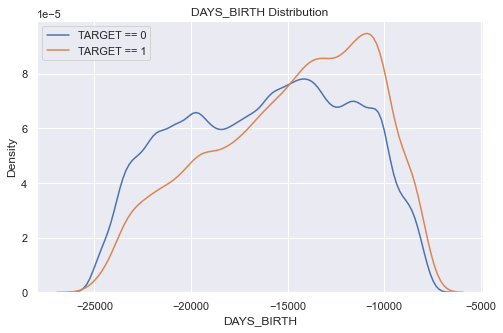

In [124]:
kde_target('DAYS_BIRTH', df_app_2)

La variable suivante a également un impact sur la cible.

La corrélation entre la variable bureau_DAYS_CREDIT_mean et la cible est de 0.0897
Valeur médiane pour les crédits non remboursés = -835.3333
Valeur médiane pour les crédits remboursés = -1067.0000


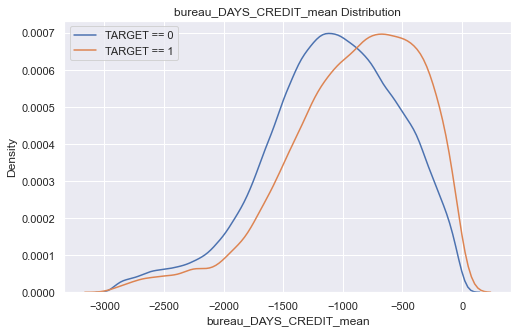

In [125]:
kde_target(var_name='bureau_DAYS_CREDIT_mean', df=df_app_2)

On présente ci-dessous les graphiques KDE et les histogrammes de trois variables qui s'avèrent être assez importantes dans les processus de décision. En effet, après plusieurs tests d'entraînements de modèles de Machine Learning, les classifieurs identifient souvent ses variables comme influentes dans le choix de la décision.

La corrélation entre la variable EXT_SOURCE_1 et la cible est de -0.1553
Valeur médiane pour les crédits non remboursés = 0.3617
Valeur médiane pour les crédits remboursés = 0.5175


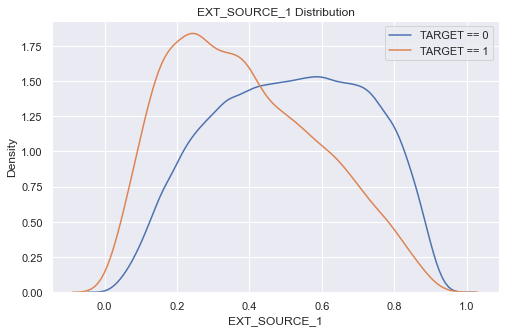

In [126]:
kde_target('EXT_SOURCE_1', df_app)

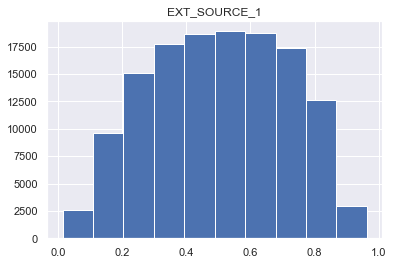

In [127]:
df_app[['EXT_SOURCE_1']].hist();

La corrélation entre la variable EXT_SOURCE_2 et la cible est de -0.1605
Valeur médiane pour les crédits non remboursés = 0.4404
Valeur médiane pour les crédits remboursés = 0.5739


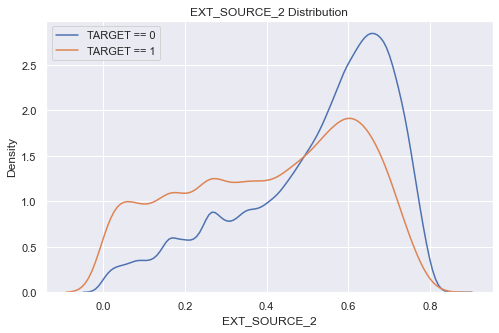

In [128]:
kde_target('EXT_SOURCE_2', df_app)

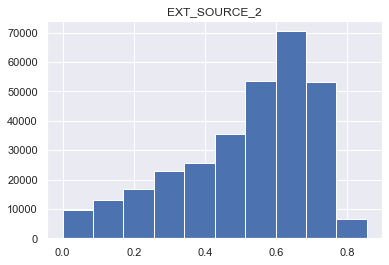

In [129]:
df_app[['EXT_SOURCE_2']].hist();

La corrélation entre la variable EXT_SOURCE_3 et la cible est de -0.1789
Valeur médiane pour les crédits non remboursés = 0.3791
Valeur médiane pour les crédits remboursés = 0.5460


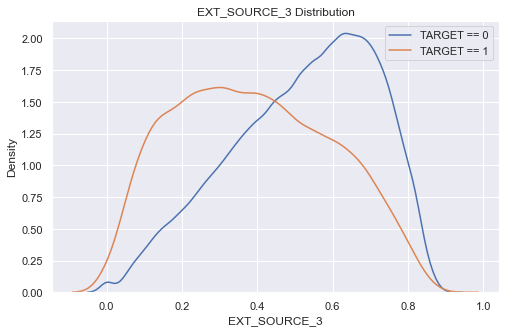

In [130]:
kde_target('EXT_SOURCE_3', df_app)

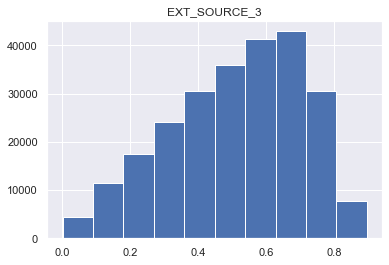

In [131]:
df_app[['EXT_SOURCE_3']].hist();

### Valeurs manquantes <a class="anchor" id="val_man"></a>

#### Fonction de calcul des valeurs manquantes

On calcule le nombre de valeurs manquantes par variable.

In [132]:
def missing_values_table(df,df_name):
    
        # Nombre total de valeurs manquantes
        mis_val = df.isnull().sum()
        
        # Pourcentage de valeurs manquantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)

        print ("Le dataframe " + df_name + " comprend " + str(df.shape[1]) + " colonnes dont " + str(mis_val_table_ren_columns.shape[0]) +
              " colonnes avec des valeurs manquantes.")

        return mis_val_table_ren_columns

In [133]:
missing_train_0 = missing_values_table(df_app_0,'df_app_0')
# missing_train_vars_0 = list(missing_train_0.index[missing_train_0['% of Total Values'] > 80])

missing_train_1 = missing_values_table(df_app_1,'df_app_1')
# missing_train_vars_1 = list(missing_train_1.index[missing_train_1['% of Total Values'] > 80])

missing_train_2 = missing_values_table(df_app_2,'df_app_2')
# missing_train_vars_2 = list(missing_train_2.index[missing_train_2['% of Total Values'] > 80])

Le dataframe df_app_0 comprend 243 colonnes dont 61 colonnes avec des valeurs manquantes.
Le dataframe df_app_1 comprend 455 colonnes dont 272 colonnes avec des valeurs manquantes.
Le dataframe df_app_2 comprend 1771 colonnes dont 1588 colonnes avec des valeurs manquantes.


On liste les variables dont le pourcentage de valeurs manquantes dépasse un certain seuil.

In [134]:
miss_r = 80

In [135]:
list(missing_train_0.index[missing_train_0['% of Total Values'] > miss_r])

[]

In [136]:
list(missing_train_1.index[missing_train_1['% of Total Values'] > miss_r])

[]

In [137]:
list(missing_train_2.index[missing_train_2['% of Total Values'] > miss_r])

['previous_application_RATE_INTEREST_PRIMARY_min',
 'previous_application_RATE_INTEREST_PRIMARY_mean',
 'previous_application_RATE_INTEREST_PRIVILEGED_min',
 'previous_application_RATE_INTEREST_PRIVILEGED_max',
 'previous_application_RATE_INTEREST_PRIVILEGED_mean',
 'previous_application_RATE_INTEREST_PRIMARY_max',
 'client_credit_card_balance_AMT_PAYMENT_CURRENT_mean_max',
 'client_credit_card_balance_AMT_PAYMENT_CURRENT_max_min',
 'client_credit_card_balance_AMT_PAYMENT_CURRENT_min_max',
 'client_credit_card_balance_AMT_PAYMENT_CURRENT_max_max',
 'client_credit_card_balance_AMT_PAYMENT_CURRENT_max_mean',
 'client_credit_card_balance_AMT_PAYMENT_CURRENT_min_min',
 'client_credit_card_balance_AMT_PAYMENT_CURRENT_mean_min',
 'client_credit_card_balance_AMT_PAYMENT_CURRENT_min_mean',
 'client_credit_card_balance_AMT_PAYMENT_CURRENT_mean_mean',
 'client_credit_card_balance_AMT_DRAWINGS_ATM_CURRENT_min_mean',
 'client_credit_card_balance_AMT_DRAWINGS_OTHER_CURRENT_max_mean',
 'client_credi

#### Fonction de traitement des valeurs manquantes

Dans le fonction **missing_val()** on supprime les variables (colonnes) d'un dataframe pour lesquelles le taux de valeurs manquantes dépasse un certain seuil.

On remplace également les NaN par **0** pour l'ensemble du dataframe.

In [138]:
import numpy as np
from sklearn.impute import SimpleImputer

def missing_val(features_processing_, df_app, df_app_name, miss_ratio):
    
    if features_processing_ == 1:
        varInfo = all_var_info(df_app,df_app_name)
        joblib.dump(varInfo, path_data+df_app_name+'_varInfo.joblib')
        
    elif features_processing_ == 0:
        varInfo = joblib.load(path_data+df_app_name+'_varInfo.joblib')
    
    plt.hist(varInfo['Null_ratio'], bins=20)
    #plt.axis([0, 1, 0, 1000])
    plt.show()
    
    print(df_app.shape)
    
    varInfo2 = varInfo[varInfo['Null_ratio'] < miss_ratio]
    varInfo2.sort_values('Null_ratio',ascending=False)
    
    plt.hist(varInfo2['Null_ratio'], bins=20)
    #plt.axis([0, 1, 0, 1000])
    plt.show()
    
    df_app = df_app[varInfo2['Variable']]
    
    # Remplacement des valeurs manquantes
    print('Jeu de données:',df_app_name)
    print('Nombre de nan:',df_app.isna().sum().sum())
    df_app = df_app.replace([np.inf, -np.inf], np.nan)
    print('Nombre de nan après remplacement de inf par nan:',df_app.isna().sum().sum())
    
#     df_app_cols = df_app.columns.tolist()
#     imput_ = SimpleImputer(missing_values=np.nan, strategy='median')
#     df_app = pd.DataFrame(imput_.fit_transform(df_app))
#     df_app.columns = df_app_cols
    
    df_app = df_app.fillna(0)
    print('Nombre de nan après remplacement:',df_app.isna().sum().sum())
    print(df_app.shape)
    
    return df_app

##### Jeu de données df_app_0

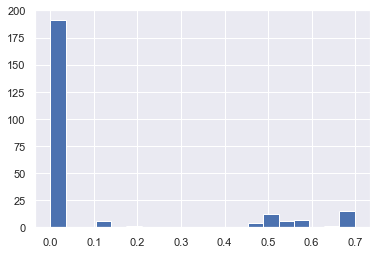

(307511, 243)


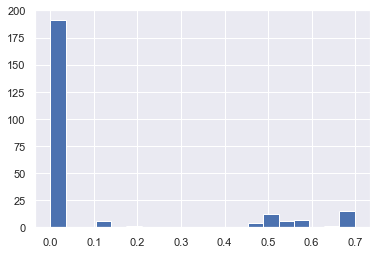

Jeu de données: df_app_0
Nombre de nan: 8388094
Nombre de nan après remplacement de inf par nan: 8388094
Nombre de nan après remplacement: 0
(307511, 243)


In [139]:
df_app_0 = missing_val(0, df_app_0, 'df_app_0', 0.80)

##### Jeu de données df_app_1

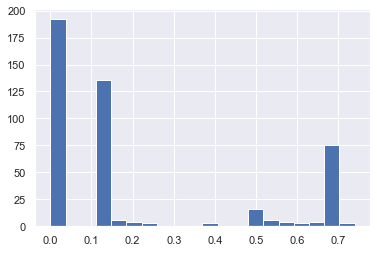

(307511, 455)


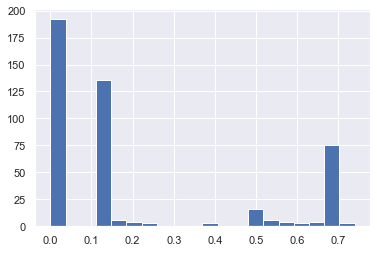

Jeu de données: df_app_1
Nombre de nan: 29446340
Nombre de nan après remplacement de inf par nan: 29446340
Nombre de nan après remplacement: 0
(307511, 455)


In [140]:
df_app_1 = missing_val(0, df_app_1, 'df_app_1', 0.80)

##### Jeu de données df_app_2

Concernant le dataset **df_app_2** on identifie plus précisément les taux de valeurs manquantes pour les variables **'EXT_SOURCE_1'**, **'EXT_SOURCE_2'** et **'EXT_SOURCE_3'** avant de les remplacer par 0 dans la fonction **missing_val()**.

In [141]:
ext1_nan = df_app_2[['EXT_SOURCE_1']].isna().sum()[0]
ext2_nan = df_app_2[['EXT_SOURCE_2']].isna().sum()[0]
ext3_nan = df_app_2[['EXT_SOURCE_3']].isna().sum()[0]

ext1_nan_ratio = round((ext1_nan / df_app.shape[0]),2)
ext2_nan_ratio = round((ext2_nan / df_app.shape[0]),2)
ext3_nan_ratio = round((ext3_nan / df_app.shape[0]),2)

print('Nombre de valeurs nulles pour la variable \'EXT_SOURCE_1\': %s (ratio = %0.02f)' % (ext1_nan, ext1_nan_ratio))
print('Nombre de valeurs nulles pour la variable \'EXT_SOURCE_2\': %s (ratio = %0.02f)' % (ext2_nan, ext2_nan_ratio))
print('Nombre de valeurs nulles pour la variable \'EXT_SOURCE_3\': %s (ratio = %0.02f)' % (ext3_nan, ext3_nan_ratio))

Nombre de valeurs nulles pour la variable 'EXT_SOURCE_1': 173378 (ratio = 0.56)
Nombre de valeurs nulles pour la variable 'EXT_SOURCE_2': 660 (ratio = 0.00)
Nombre de valeurs nulles pour la variable 'EXT_SOURCE_3': 60965 (ratio = 0.20)


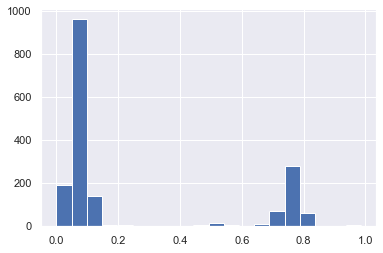

(307511, 1771)


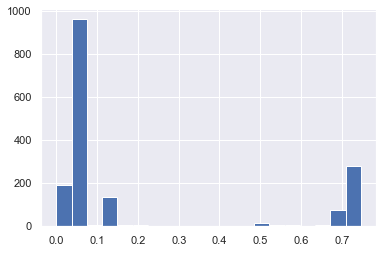

Jeu de données: df_app_2
Nombre de nan: 110236194
Nombre de nan après remplacement de inf par nan: 110236194
Nombre de nan après remplacement: 0
(307511, 1702)


In [142]:
df_app_2 = missing_val(0, df_app_2, 'df_app_2', 0.80)

In [143]:
df_app_2.shape

(307511, 1702)

On vérifie que les NaN ont bien été remplacés.

In [144]:
df_app_2.isna().sum().sum()

0

In [145]:
df_app_2['EXT_SOURCE_1'].isna().sum()

0

In [146]:
df_app_2['EXT_SOURCE_2'].isna().sum()

0

In [147]:
df_app_2['EXT_SOURCE_3'].isna().sum()

0

##### Jeu de données df_app_test_2 (sans étiquette)

#### Remplacement des valeurs nulles pour la base de test sans étiquette

In [148]:
df_app_test_2 = df_app_test_2.fillna(0)

Concernant la base de test sans étiquette, nous ne remplaçons pas les valeurs manquantes. Aucune méthode n'étant parfaite, il est préférable de laisser les NaN. Les technologies utilisées permettent de gérer les NaN.

In [149]:
df_app_test_2.isna().sum().sum()

0

In [150]:
df_app_test_2['EXT_SOURCE_1'].isna().sum()

0

In [151]:
df_app_test_2['EXT_SOURCE_2'].isna().sum()

0

In [152]:
df_app_test_2['EXT_SOURCE_3'].isna().sum()

0

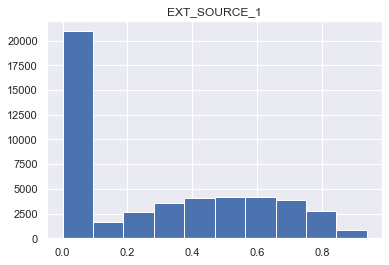

In [153]:
df_app_test_2[['EXT_SOURCE_1']].hist();

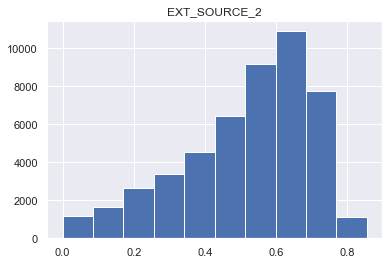

In [154]:
df_app_test_2[['EXT_SOURCE_2']].hist();

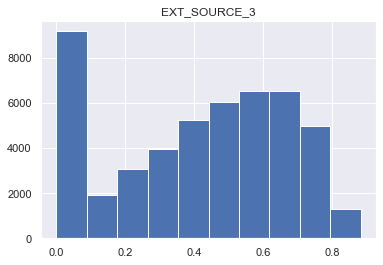

In [155]:
df_app_test_2[['EXT_SOURCE_3']].hist();

##### Jeu de données df_app_2

#### Graphes KDE après remplacement des valeurs manquantes par 0

On affiche les graphes KDE après remplacement des NaN par 0.

La corrélation entre la variable EXT_SOURCE_1 et la cible est de -0.0647
Valeur médiane pour les crédits non remboursés = 0.0000
Valeur médiane pour les crédits remboursés = 0.0000


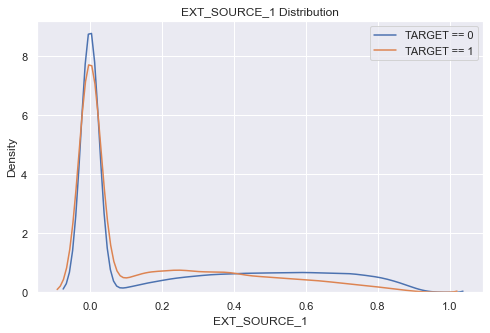

In [156]:
kde_target('EXT_SOURCE_1', df_app_2)

La corrélation entre la variable EXT_SOURCE_2 et la cible est de -0.1590
Valeur médiane pour les crédits non remboursés = 0.4395
Valeur médiane pour les crédits remboursés = 0.5734


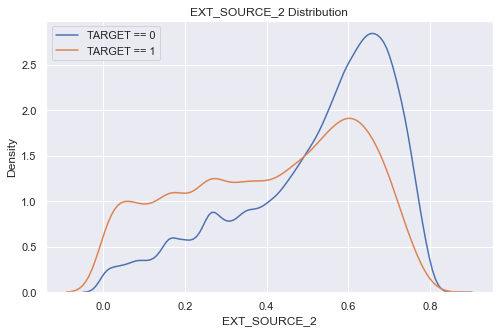

In [157]:
kde_target('EXT_SOURCE_2', df_app_2)

La corrélation entre la variable EXT_SOURCE_3 et la cible est de -0.1196
Valeur médiane pour les crédits non remboursés = 0.2881
Valeur médiane pour les crédits remboursés = 0.4741


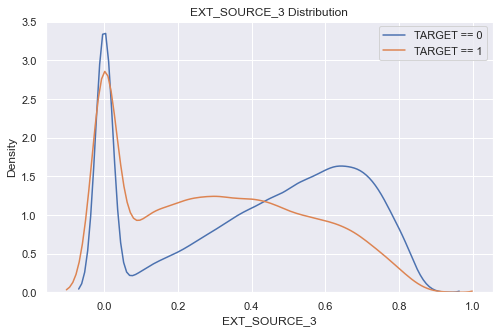

In [158]:
kde_target('EXT_SOURCE_3', df_app_2)

On constate que les graphes KDE ont été modifiés, en particulier pour les variables **'EXT_SOURCE_1'** et **'EXT_SOURCE_3'**. En effet, ces variables présentaient un taux assez important de valeurs nulles. En remplacant ces valeurs nulles par 0, on affecte donc de beaucoup les distributions.

Le code qui suit permet d'appliquer une stratégie de remplacement des valeurs nulles par groupe d'individus selon leur classe (0 ou 1).

Nous avons obtenus de meilleurs résultats avec les valeurs médianes (`SimpleImputer`) comme valeurs de remplacement (plutôt que 0).

>Nous avons obtenus des résultats plus conformes avec les KDE de référence en utilisant `KNNImputer`.

#### Méthodes de remplacement des valeurs manquantes

In [159]:
from sklearn.impute import SimpleImputer, KNNImputer

# imput_ = SimpleImputer(missing_values=np.nan, strategy='median', add_indicator=True)
imput_ = KNNImputer(missing_values=np.nan, add_indicator=True)

# On définit un dataframe contenant uniquement les variables 'EXT_SOURCE...' et la variable 'TARGET'
df_ext = df_app_2[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','TARGET']]

# On récupère les individus pour lesquelles la cible est 0
df_ext_0 = df_ext[df_ext['TARGET']==0]
# On sauvegarde les index
df_ext_0_index = df_ext_0.index.tolist()
# On enlève la variable 'TARGET'
df_ext_0 = df_ext_0[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]

print(df_ext_0.head())

# On récupère les individus pour lesquelles la cible est 1
df_ext_1 = df_ext[df_ext['TARGET']==1]
# On sauvegarde les index
df_ext_1_index = df_ext_1.index.tolist()
# On enlève la variable 'TARGET'
df_ext_1 = df_ext_1[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]

print('')
print(df_ext_1.head())

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3
1      0.311267      0.622246      0.000000
2      0.000000      0.555912      0.729567
3      0.000000      0.650442      0.000000
4      0.000000      0.322738      0.000000
5      0.000000      0.354225      0.621226

    EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3
0       0.083037      0.262949      0.139376
26      0.000000      0.548477      0.190706
40      0.000000      0.306841      0.320163
42      0.468208      0.674203      0.399676
81      0.000000      0.023952      0.720944


##### Jeu de données df_app_2

In [160]:
df_app_name='df_app_2'

In [161]:
miss_proc_ = 0

if miss_proc_ == 1:
    df_ext_0 = pd.DataFrame(imput_.fit_transform(df_ext_0))
    df_ext_0['index'] = df_ext_0_index
    joblib.dump(df_ext_0, path_data+df_app_name+'_df_ext_0.joblib')
    
    df_ext_1 = pd.DataFrame(imput_.fit_transform(df_ext_1))
    df_ext_1['index'] = df_ext_1_index
    joblib.dump(df_ext_1, path_data+df_app_name+'_df_ext_1.joblib')

if miss_proc_ == 0:
    df_ext_0 = joblib.load(path_data+df_app_name+'_df_ext_0.joblib')
    df_ext_1 = joblib.load(path_data+df_app_name+'_df_ext_1.joblib') 

In [162]:
df_ext = pd.concat([df_ext_0, df_ext_1], axis=0)
df_ext = df_ext.sort_values('index')
df_ext

,0,1,2,3,4,5,index
0,0.083037,0.262949,0.139376,0.0,0.0,0.0,0
0,0.311267,0.622246,0.598382,0.0,0.0,1.0,1
1,0.483106,0.555912,0.729567,1.0,0.0,0.0,2
2,0.658033,0.650442,0.514082,1.0,0.0,1.0,3
3,0.531240,0.322738,0.599200,1.0,0.0,1.0,4
...,...,...,...,...,...,...,...
282682,0.145570,0.681632,0.387374,0.0,0.0,1.0,307506
282683,0.408782,0.115992,0.530624,1.0,0.0,1.0,307507
282684,0.744026,0.535722,0.218859,0.0,0.0,0.0,307508
24824,0.420143,0.514163,0.661024,1.0,0.0,0.0,307509


In [163]:
df_ext.reset_index(drop=True, inplace=True)
df_ext

,0,1,2,3,4,5,index
0,0.083037,0.262949,0.139376,0.0,0.0,0.0,0
1,0.311267,0.622246,0.598382,0.0,0.0,1.0,1
2,0.483106,0.555912,0.729567,1.0,0.0,0.0,2
3,0.658033,0.650442,0.514082,1.0,0.0,1.0,3
4,0.531240,0.322738,0.599200,1.0,0.0,1.0,4
...,...,...,...,...,...,...,...
307506,0.145570,0.681632,0.387374,0.0,0.0,1.0,307506
307507,0.408782,0.115992,0.530624,1.0,0.0,1.0,307507
307508,0.744026,0.535722,0.218859,0.0,0.0,0.0,307508
307509,0.420143,0.514163,0.661024,1.0,0.0,0.0,307509


In [164]:
del df_ext['index']

In [165]:
df_ext

,0,1,2,3,4,5
0,0.083037,0.262949,0.139376,0.0,0.0,0.0
1,0.311267,0.622246,0.598382,0.0,0.0,1.0
2,0.483106,0.555912,0.729567,1.0,0.0,0.0
3,0.658033,0.650442,0.514082,1.0,0.0,1.0
4,0.531240,0.322738,0.599200,1.0,0.0,1.0
...,...,...,...,...,...,...
307506,0.145570,0.681632,0.387374,0.0,0.0,1.0
307507,0.408782,0.115992,0.530624,1.0,0.0,1.0
307508,0.744026,0.535722,0.218859,0.0,0.0,0.0
307509,0.420143,0.514163,0.661024,1.0,0.0,0.0


In [166]:
df_ext.columns = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','ES1','ES2','ES3']

In [167]:
df_ext

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,ES1,ES2,ES3
0,0.083037,0.262949,0.139376,0.0,0.0,0.0
1,0.311267,0.622246,0.598382,0.0,0.0,1.0
2,0.483106,0.555912,0.729567,1.0,0.0,0.0
3,0.658033,0.650442,0.514082,1.0,0.0,1.0
4,0.531240,0.322738,0.599200,1.0,0.0,1.0
...,...,...,...,...,...,...
307506,0.145570,0.681632,0.387374,0.0,0.0,1.0
307507,0.408782,0.115992,0.530624,1.0,0.0,1.0
307508,0.744026,0.535722,0.218859,0.0,0.0,0.0
307509,0.420143,0.514163,0.661024,1.0,0.0,0.0


##### Jeu de données de test df_app_test_2 (sans étiquette)

Concernant la base de test sans étiquette , comme nous ne disposons pas des étiquettes (valeurs cibles), on doit réaliser le traitement globalement sans prendre en compte les classes des individus.

In [168]:
imput_ = KNNImputer(missing_values=np.nan, add_indicator=True) # ou most frequent au cas ou var cat

# On définit un dataframe contenant uniquement les variables 'EXT_SOURCE...' et la variable 'TARGET'
df_ext_sub = df_app_test_2[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]

# On sauvegarde les index
df_ext_sub_index = df_ext_sub.index.tolist()
# On enlève la variable 'TARGET'
df_ext_sub = df_ext_sub[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]

print(df_ext_sub.head())

miss_proc_ = 0

if miss_proc_ == 1:
    df_ext_sub = pd.DataFrame(imput_.fit_transform(df_ext_sub))
    df_ext_sub['index'] = df_ext_sub_index
    joblib.dump(df_ext_sub, path_data+df_app_name+'_df_ext_sub.joblib')

if miss_proc_ == 0:
    df_ext_sub = joblib.load(path_data+df_app_name+'_df_ext_sub.joblib')

df_ext_sub = df_ext_sub.sort_values('index')
df_ext_sub.reset_index(drop=True, inplace=True)

del df_ext_sub['index']

df_ext_sub.columns = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','ES1','ES2','ES3']

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3
0      0.752614      0.789654      0.159520
1      0.564990      0.291656      0.432962
2      0.000000      0.699787      0.610991
3      0.525734      0.509677      0.612704
4      0.202145      0.425687      0.000000


En affectant **1** au paramètre *imput_*, on remplace les valeurs des variables **'EXT_SOURCE...'** (dont les NaN ont été remplacés par 0), par les valeurs obtenues avec `KNNImputer`.

In [169]:
imput_ = 1

if imput_ == 1:
    df_app_2 = df_app_2.drop(columns=['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'])
    df_app_2 = df_app_2.merge(df_ext, left_index=True, right_index=True)
    df_miss_indic = df_app_2[['SK_ID_CURR','ES1','ES2','ES3']].copy()
    df_app_2 = df_app_2.drop(columns=['ES1','ES2','ES3'])
    
    df_app_test_2 = df_app_test_2.drop(columns=['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'])
    df_app_test_2 = df_app_test_2.merge(df_ext_sub, left_index=True, right_index=True)
    df_miss_indic_sub = df_app_test_2[['SK_ID_CURR','ES1','ES2','ES3']].copy()
    df_app_test_2 = df_app_test_2.drop(columns=['ES1','ES2','ES3'])

In [170]:
df_app_2.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_sum,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_count,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_mean,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_max,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_min,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_sum,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.083037,0.262949,0.139376
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.311267,0.622246,0.598382
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.483106,0.555912,0.729567
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0.658033,0.650442,0.514082
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.531240,0.322738,0.599200


In [171]:
df_app_test_2.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_min,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_sum,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_count,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_mean,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_max,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_min,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_sum,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.752614,0.789654,0.159520
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.564990,0.291656,0.432962
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,-2175.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.472158,0.699787,0.610991
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,-2000.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.525734,0.509677,0.612704
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,-4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.202145,0.425687,0.422334


#### Graphes KDE après remplacement des valeurs manquantes avec la méthode des plus proches voisins

##### Jeu de données df_app_2

La corrélation entre la variable EXT_SOURCE_1 et la cible est de -0.2108
Valeur médiane pour les crédits non remboursés = 0.3640
Valeur médiane pour les crédits remboursés = 0.5028


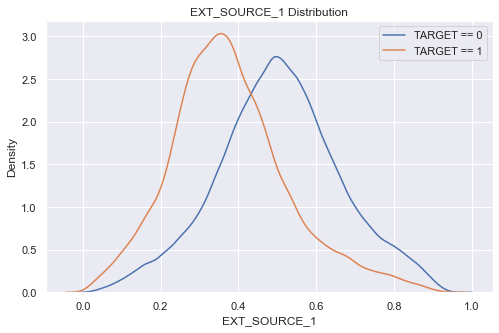

In [172]:
kde_target('EXT_SOURCE_1', df_app_2)

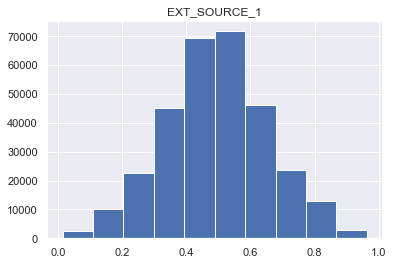

In [173]:
df_app_2[['EXT_SOURCE_1']].hist();

La corrélation entre la variable EXT_SOURCE_2 et la cible est de -0.1606
Valeur médiane pour les crédits non remboursés = 0.4400
Valeur médiane pour les crédits remboursés = 0.5737


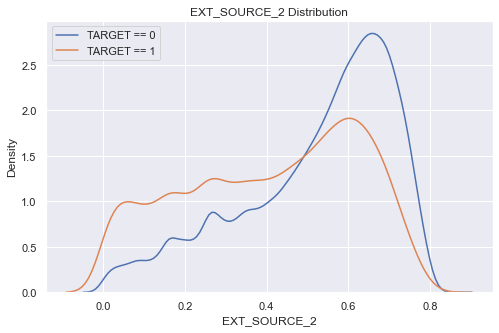

In [174]:
kde_target('EXT_SOURCE_2', df_app_2)

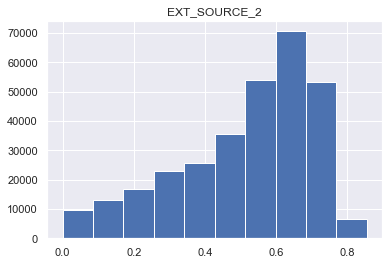

In [175]:
df_app_2[['EXT_SOURCE_2']].hist();

La corrélation entre la variable EXT_SOURCE_3 et la cible est de -0.1979
Valeur médiane pour les crédits non remboursés = 0.3858
Valeur médiane pour les crédits remboursés = 0.5394


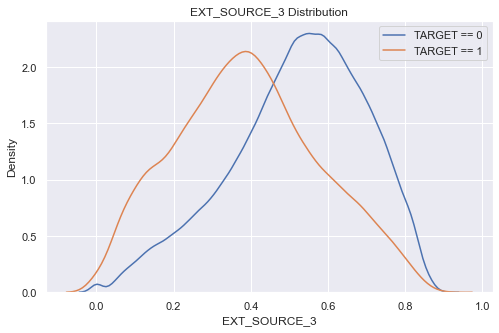

In [176]:
kde_target('EXT_SOURCE_3', df_app_2)

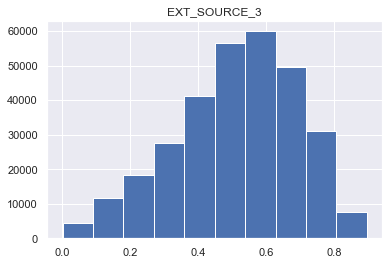

In [177]:
df_app_2[['EXT_SOURCE_3']].hist();

##### Jeu de données df_app_test_2 (sans étiquette)

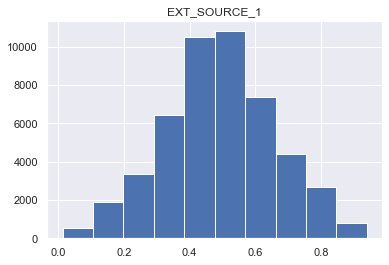

In [178]:
df_app_test_2[['EXT_SOURCE_1']].hist();

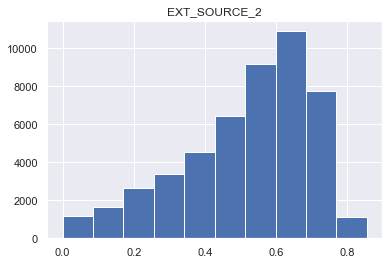

In [179]:
df_app_test_2[['EXT_SOURCE_2']].hist();

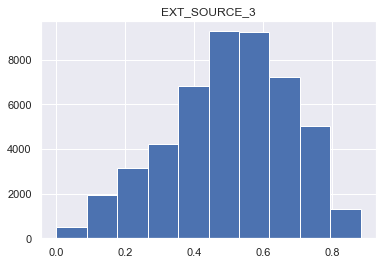

In [180]:
df_app_test_2[['EXT_SOURCE_3']].hist();

#### Validation

In [181]:
df_app_0.head(2)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,0,0,0,0,0,1,0,1,0,1
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,1,0,0,0,0,0,0,1,0,0


In [182]:
df_app_1.head(2)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum,TARGET
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,1.875,3.0,0.0,15.0,8.0,0.161932,0.5,0.0,1.295455,1
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0


In [183]:
df_app_2.head(2)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_sum,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_count,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_mean,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_max,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_min,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_sum,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.083037,0.262949,0.139376
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.311267,0.622246,0.598382


In [184]:
df_app_test_2.head(2)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_min,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_sum,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_count,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_mean,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_max,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_min,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_sum,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.752614,0.789654,0.159520
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.564990,0.291656,0.432962


In [185]:
print('df_app_0',df_app_0.shape)
print('df_app_1',df_app_1.shape)
print('df_app_2',df_app_2.shape)

df_app_0 (307511, 243)
df_app_1 (307511, 455)
df_app_2 (307511, 1702)


In [186]:
df_app_0.isna().sum().sum()

0

In [187]:
df_app_1.isna().sum().sum()

0

In [188]:
df_app_2.isna().sum().sum()

0

In [189]:
df_app_test_2.isna().sum().sum()

0

In [190]:
df_app_test_2[['EXT_SOURCE_1']].isna().sum()

EXT_SOURCE_1    0
dtype: int64

In [191]:
df_app_test_2[['EXT_SOURCE_2']].isna().sum()

EXT_SOURCE_2    0
dtype: int64

In [192]:
df_app_test_2[['EXT_SOURCE_3']].isna().sum()

EXT_SOURCE_3    0
dtype: int64

In [193]:
time_calc('Traitement des valeurs manquantes','155',1)
t = time.time()

Durée de l'opération 'Traitement des valeurs manquantes': 135.03 s
Durée totale de traitement: 00 h 12 m 21 s


### Corrélations <a class="anchor" id="cor"></a>

In [194]:
df_app = df_app_2.copy()
df_app_name = 'df_app_2'

In [195]:
t = time.time()

corr_1 = 0

if corr_1 == 1:

    # Calcul des corrélations pour l'ensemble des variables du dataframe
    corrs = df_app.corr()
    joblib.dump(corrs, path_data+df_app_name+'_corrs.joblib')

if corr_1 == 0:
    
    corrs = joblib.load(path_data+df_app_name+'_corrs.joblib')

#### Corrélations de variables entre elles

Les variables fortement corrélées entre elles ne présentent pas grand intérêt pour le Machine Learning.

>Dans un but de réduction du nombre de variables, on cherche les variables qui ont une corrélation supérieure à un **seuil de corrélation** avec d'autres variables.

In [196]:
thr_corr = 0.95
print('Le seuil de corrélation est fixé à:',thr_corr)

Le seuil de corrélation est fixé à: 0.95


La matrice des corrélations est **corrs**.

In [197]:
corrs

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_mean,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_max,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_min,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_sum,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_count,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_mean,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_max,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_min,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_sum,TARGET
SK_ID_CURR,1.000000,-0.001129,-0.001820,-0.000343,-0.000407,-0.000390,0.000849,-0.001500,0.001366,-0.000973,...,0.000676,0.000733,0.000619,0.000726,0.002002,-0.002979,-0.003201,-0.002721,-0.003205,-0.002108
CNT_CHILDREN,-0.001129,1.000000,0.012882,0.002145,0.021414,-0.002008,-0.025573,0.330938,-0.239818,0.183395,...,0.002765,0.002736,0.002794,0.002747,0.003022,0.001590,0.001322,0.001848,0.001327,0.019187
AMT_INCOME_TOTAL,-0.001820,0.012882,1.000000,0.156870,0.191639,0.159664,0.074796,0.027261,-0.064223,0.027805,...,0.001104,0.001097,0.001111,0.001096,0.014659,0.000603,0.000537,0.000663,0.000537,-0.003982
AMT_CREDIT,-0.000343,0.002145,0.156870,1.000000,0.770080,0.986687,0.099738,-0.055436,-0.066838,0.009621,...,0.010758,0.010788,0.010726,0.010787,0.013549,0.003426,0.003562,0.003250,0.003561,-0.030369
AMT_ANNUITY,-0.000407,0.021414,0.191639,0.770080,1.000000,0.775063,0.118345,0.009419,-0.104290,0.038516,...,0.004979,0.005005,0.004953,0.005008,-0.000113,-0.000284,-0.000173,-0.000395,-0.000171,-0.012794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_mean,-0.002979,0.001590,0.000603,0.003426,-0.000284,0.002218,0.000166,0.000988,-0.005606,0.001345,...,0.594910,0.595153,0.594496,0.595164,0.105605,1.000000,0.994831,0.994606,0.994824,0.001888
client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_max,-0.003201,0.001322,0.000537,0.003562,-0.000173,0.002382,0.000174,0.000842,-0.005500,0.001391,...,0.586036,0.586772,0.585133,0.586797,0.106201,0.994831,1.000000,0.978933,0.999999,0.001813
client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_min,-0.002721,0.001848,0.000663,0.003250,-0.000395,0.002027,0.000155,0.001126,-0.005654,0.001283,...,0.597624,0.597362,0.597715,0.597359,0.103870,0.994606,0.978933,1.000000,0.978919,0.001945
client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_sum,-0.003205,0.001327,0.000537,0.003561,-0.000171,0.002381,0.000174,0.000844,-0.005501,0.001391,...,0.586030,0.586765,0.585127,0.586794,0.106209,0.994824,0.999999,0.978919,1.000000,0.001821


Nous représentons ci-dessous une *heatmap* sur un échantillon de **corrs**.

On voit que chaque variable est évidemment totalement corrélée avec elle-même.

On voit également que la variable **'AMT_CREDIT'** est fortement corrélée avec la variable **'AMT_GOODS_PRICE'**

In [198]:
i = 0
corrs.iloc[i:i+6,i:i+6].style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'))

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE
SK_ID_CURR,1.0,-0.0011,-0.0018,-0.00034,-0.00041,-0.00039
CNT_CHILDREN,-0.0011,1.0,0.013,0.0021,0.021,-0.002
AMT_INCOME_TOTAL,-0.0018,0.013,1.0,0.16,0.19,0.16
AMT_CREDIT,-0.00034,0.0021,0.16,1.0,0.77,0.99
AMT_ANNUITY,-0.00041,0.021,0.19,0.77,1.0,0.78
AMT_GOODS_PRICE,-0.00039,-0.002,0.16,0.99,0.78,1.0


In [199]:
print('On filtre la matrice corrs sur la valeur du seuil de corrélation:',thr_corr)

On filtre la matrice corrs sur la valeur du seuil de corrélation: 0.95


In [200]:
corrs_filt = corrs > thr_corr

On cherche à identifier toutes les paires de variables qui présentent une corrélation supérieure au seuil.

La fonction **var_corrs()** prend en entier le nom d'une variable et la valeur du seuil. Elle retourne les variables corrélées à cette variable dans un dictionnaire (clé = variable; valeurs = variables corrélées).

In [201]:
def var_corrs(col='AMT_CREDIT',threshold=thr_corr):

    # On créé un dictionnaire pour stocker les variables (clés) et les variables corrélées (valeurs)
    dic_var_corrs = {}

    title = 'Identification des variables corrélées à la variable:'
    print(title,col)
    print('_'*(len(title)+len(col)+1))
    print('')

    # On cherche les variables corrélées avec la variable col
    title='Identification des variables corrélées'
    print(title)
    print('-'*len(title))
    print((corrs[col] > threshold).head())

    # On stocke les variables corrélées dans une liste
    title='Liste des variables corrélées'
    print('')
    print(title)
    print('-'*len(title))
    print(list(corrs.index[corrs[col] > threshold]))

    # On rajoute la variable col comme clé du dictionnaire et les variables corrélées comme valeurs
    dic_var_corrs[col] = list(corrs.index[corrs[col] > threshold])
    
    dic_var_corrs
    
    title='Dictionnaire'
    print('')
    print(title)
    print('-'*len(title))
    print(dic_var_corrs)

    # Valeurs des variables corrélées
    title='Valeurs des variables corrélées'
    print('')
    print(title)
    print('-'*len(title))
    print(df_app[list(corrs.index[corrs[col] > threshold])])

In [202]:
var_corrs('AMT_CREDIT')

Identification des variables corrélées à la variable: AMT_CREDIT
________________________________________________________________

Identification des variables corrélées
--------------------------------------
SK_ID_CURR          False
CNT_CHILDREN        False
AMT_INCOME_TOTAL    False
AMT_CREDIT           True
AMT_ANNUITY         False
Name: AMT_CREDIT, dtype: bool

Liste des variables corrélées
-----------------------------
['AMT_CREDIT', 'AMT_GOODS_PRICE']

Dictionnaire
------------
{'AMT_CREDIT': ['AMT_CREDIT', 'AMT_GOODS_PRICE']}

Valeurs des variables corrélées
-------------------------------
        AMT_CREDIT  AMT_GOODS_PRICE
0         406597.5         351000.0
1        1293502.5        1129500.0
2         135000.0         135000.0
3         312682.5         297000.0
4         513000.0         513000.0
...            ...              ...
307506    254700.0         225000.0
307507    269550.0         225000.0
307508    677664.0         585000.0
307509    370107.0         319500.

In [203]:
var_corrs('APARTMENTS_MODE')

Identification des variables corrélées à la variable: APARTMENTS_MODE
_____________________________________________________________________

Identification des variables corrélées
--------------------------------------
SK_ID_CURR          False
CNT_CHILDREN        False
AMT_INCOME_TOTAL    False
AMT_CREDIT          False
AMT_ANNUITY         False
Name: APARTMENTS_MODE, dtype: bool

Liste des variables corrélées
-----------------------------
['APARTMENTS_AVG', 'APARTMENTS_MODE', 'APARTMENTS_MEDI']

Dictionnaire
------------
{'APARTMENTS_MODE': ['APARTMENTS_AVG', 'APARTMENTS_MODE', 'APARTMENTS_MEDI']}

Valeurs des variables corrélées
-------------------------------
        APARTMENTS_AVG  APARTMENTS_MODE  APARTMENTS_MEDI
0               0.0247           0.0252           0.0250
1               0.0959           0.0924           0.0968
2               0.0000           0.0000           0.0000
3               0.0000           0.0000           0.0000
4               0.0000           0.0000    

On identifie l'ensemble des variables corrélées que l'on stocke dans un dictionnaire.

In [204]:
corr_2 = 1

if corr_2 == 1:

    # Initialisation du dictionnaire
    dic_var_corrs = {}

    # On stocke dans le dictionnaire les variables au-dessus du seuil
    for col in corrs: # Pour chaque colonne (variable) de corrs
        dic_var_corrs[col] = list(corrs.index[corrs[col] > thr_corr])

In [205]:
# Dans cet exemple, la variable est uniquement corrélée avec elle-même
dic_var_corrs['CNT_CHILDREN']

['CNT_CHILDREN']

In [206]:
# Dans cet exemple, la variable est corrélée avec elle-même et une autre variable
dic_var_corrs['AMT_CREDIT']

['AMT_CREDIT', 'AMT_GOODS_PRICE']

In [207]:
# Dans cet exemple, la variable est corrélée avec elle-même et deux autres variables
dic_var_corrs['DAYS_EMPLOYED']

['DAYS_EMPLOYED', 'NAME_INCOME_TYPE_Pensioner', 'ORGANIZATION_TYPE_XNA']

In [208]:
# Cet exemple et le suivant montrent la réciprocité de la corrélation
dic_var_corrs['APARTMENTS_AVG']

['APARTMENTS_AVG', 'APARTMENTS_MODE', 'APARTMENTS_MEDI']

In [209]:
dic_var_corrs['APARTMENTS_MEDI']

['APARTMENTS_AVG', 'APARTMENTS_MODE', 'APARTMENTS_MEDI']

Pour chacune des paires de variables corrélées sur la base du seuil, nous supprimons une des variables.

In [210]:
if corr_2 == 1:
    
    # Initialisation de la liste des colonnes à supprimer
    cols_to_remove = []
    # Initialisation de la liste des colonnes traitées
    cols_processed = []
    # Initialisation de la liste des colonnes à supprimer
    cols_to_keep = []

    # Itération sur les colonnes
    for key, value in dic_var_corrs.items():
        # Colonnes déjà traitées
        cols_processed.append(key)
        for val in value:
            if val == key:
                next
            else:
                # Suppression d'une colonne de chaque paire
                if val not in cols_processed:
                    cols_to_remove.append(val)
                    cols_to_keep.append(key)

    cols_to_remove = list(set(cols_to_remove))
    print('Nombre de variables à supprimer: ', len(cols_to_remove))

Nombre de variables à supprimer:  789


Liste des variables traitées.

In [211]:
cols_processed[0:20]

['SK_ID_CURR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT']

Liste des variables à supprimer.

In [212]:
cols_to_remove[0:20]

['client_credit_card_balance_AMT_CREDIT_LIMIT_ACTUAL_mean_max',
 'client_credit_card_balance_AMT_INST_MIN_REGULARITY_mean_max',
 'client_credit_card_balance_AMT_PAYMENT_CURRENT_min_count',
 'NAME_INCOME_TYPE_Pensioner',
 'BASEMENTAREA_MEDI',
 'previous_application_DAYS_TERMINATION_count',
 'client_credit_card_balance_CNT_DRAWINGS_CURRENT_mean_min',
 'client_credit_card_balance_SK_DPD_max_min',
 'client_POS_CASH_balance_CNT_INSTALMENT_max_max',
 'client_credit_card_balance_AMT_RECIVABLE_max_max',
 'previous_application_SELLERPLACE_AREA_min',
 'client_credit_card_balance_AMT_RECEIVABLE_PRINCIPAL_min_min',
 'previous_application_DAYS_LAST_DUE_count',
 'client_installments_payments_DAYS_ENTRY_PAYMENT_max_min',
 'bureau_DAYS_CREDIT_UPDATE_count',
 'previous_application_DAYS_DECISION_count',
 'client_credit_card_balance_CNT_DRAWINGS_CURRENT_sum_max',
 'previous_application_AMT_CREDIT_min',
 'client_credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_sum',
 'client_credit_card_balanc

Liste des variables à conserver.

In [213]:
cols_to_keep[0:20]

['AMT_CREDIT',
 'DAYS_EMPLOYED',
 'DAYS_EMPLOYED',
 'REGION_RATING_CLIENT',
 'APARTMENTS_AVG',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG']

Chaque variable à conserver a été enregistrée dans la la liste **cols_to_keep** à chaque fois qu'elle était impliquée dans une relation de corrélation.

On calcule ci-dessous le nombre de variables corrélées (et donc à supprimer) avec chaque variable à conserver.

In [214]:
cols_to_keep_n = pd.DataFrame(cols_to_keep)
cols_to_keep_n.columns = ['Variable']
cols_to_keep_n.groupby('Variable')['Variable'].count().head(20)

Variable
AMT_CREDIT               1
APARTMENTS_AVG           2
APARTMENTS_MODE          1
BASEMENTAREA_AVG         2
BASEMENTAREA_MODE        1
COMMONAREA_AVG           2
COMMONAREA_MODE          1
DAYS_EMPLOYED            2
ELEVATORS_AVG            2
ELEVATORS_MODE           1
ENTRANCES_AVG            2
ENTRANCES_MODE           1
FLOORSMAX_AVG            2
FLOORSMAX_MODE           1
FLOORSMIN_AVG            2
FLOORSMIN_MODE           1
LANDAREA_AVG             2
LANDAREA_MODE            1
LIVINGAPARTMENTS_AVG     2
LIVINGAPARTMENTS_MODE    1
Name: Variable, dtype: int64

On supprimer les variables corrélées.

In [215]:
if corr_2 == 1:
    df_app = df_app.drop(columns = cols_to_remove)
    print('Dimensions du dataframe après suppression des variables: ', df_app.shape)

Dimensions du dataframe après suppression des variables:  (307511, 913)


In [216]:
df_app_2 = df_app
print('df_app',df_app.shape)
print('df_app_2',df_app_2.shape)

df_app (307511, 913)
df_app_2 (307511, 913)


In [217]:
time_calc('Corrélations','2455')
t = time.time()

Durée de l'opération 'Corrélations': 8.27 s


### Export des données <a class="anchor" id="exp_don"></a>

In [218]:
print('df_app_0',df_app_0.shape)
print('df_app_1',df_app_1.shape)
print('df_app_2',df_app_2.shape)
print('df_app_test_2',df_app_test_2.shape)

joblib.dump(df_app_0,path_data+'df_app_0.joblib')
joblib.dump(df_app_1,path_data+'df_app_1.joblib')
joblib.dump(df_app_2,path_data+'df_app_2.joblib')
joblib.dump(df_app_test_2,path_data+'df_app_test_2.joblib')

df_app_0 (307511, 243)
df_app_1 (307511, 455)
df_app_2 (307511, 913)
df_app_test_2 (48744, 1770)


['../OC_DS_P7/data/df_app_test_2.joblib']

In [219]:
time_calc('Sauvegarde des données','',1,1)
t = time.time()

Durée de l'opération 'Sauvegarde des données': 23.13 s
Durée totale de traitement: 00 h 12 m 52 s

Durée des opérations
--------------------
                                Opération   Durée Estimation
0   Récupération des données (import csv)   55.41           
1               Description des variables    0.76           
2                      bureau - process 1   40.67           
3              bureau_balance - process 1   29.92           
4                      bureau - process 2   26.12           
5              bureau_balance - process 2   45.60           
6        previous_application - process 2   71.52           
7            POS_CASH_balance - process 2   71.69           
8       installments_payments - process 2   52.45           
9         credit_card_balance - process 2  114.64           
10  Fusion des dataframes (1) - process 2   26.63           
11  Fusion des dataframes (2) - process 2   70.98        365
12      Traitement des valeurs manquantes  135.03        155
13   